TODO:  
- Also, add the evolution in time for those plots in someway (like 3d plots or more plots in different time steps)
      
- add plot of the pulled arms in step 1

OBS:  
- sklearn.gaussian_process does not update in an online way, every new data it updates by fitting again all the points => it's slow  
    so, for now I'm just running the examples with T<100 and not so  number of experiments <50
     

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

User Class

In [3]:
class UserClass:
    """
    F1 and F2: in {0,1}
        are the binary features
    n_daily_clicks_function: it is a function
        represents the number of clicks given a bid
    cum_daily_costs: it is a function
        represents the cost given a bid
    conversion_rate: a function with image in [0,1] (com: usually descendent)
        it represent how a user is likely to buy the product given a price
        Obs:
        |   in the text says to consider just 5 prices, maybe we can consider this as an array instead of a function
        |__

    """

    def __init__(self, F1, F2, n_daily_clicks_function, cum_daily_costs_function, conversion_rate_function):
        self.F1 = F1
        self.F2 = F2
        self.n_daily_clicks_function = n_daily_clicks_function
        self.cum_daily_costs_function = cum_daily_costs_function
        self.conversion_rate_function = conversion_rate_function



Basic Environments

In [4]:
class PricingEnvironment:

    def __init__(self, prices, margin, user_class):
        """
        PARAMETERS:
            prices: list or array of numbers
                it is the set of prices we will use, since we are discretizing the problem
                eg: an array of 5
            
            margin: int  TODO SBAGLIATO (per ora lascio il nome uguale se no' rompo tutto
                                        ma va cambiato con il cost:
                                        il margine cambia a seconda del prezzo a cui vendi il prodotto)

            user_calss: UserClass type
        """
        self.n_arms = len(prices)
        self.prices = prices
        self.cost = margin
        # self.user_class = user_class
        self.convertion_probabilities = [user_class.conversion_rate_function(p) for p in prices]


    def round(self, pulled_arm, n_daily_clicks, cum_daily_costs):
        alpha = self.convertion_probabilities[pulled_arm]
        reward = np.random.binomial(n_daily_clicks, alpha) * (self.prices[pulled_arm] - self.cost) - cum_daily_costs
        return reward

In [5]:
class BiddingEnvironment:#or maybe call it AdvertisingEnvironment
    def __init__(self, bids, sigma_clicks, sigma_costs, user_class):
        """
        n_arms: integer

        prices: array
            it is the set of prices we will use, since we are discretizing the problem
            eg: an array of 5
        """
        self.bids = bids
        # self.n_arms = len(bids)
        # self.user_class = user_class

        self.mean_clicks = [user_class.n_daily_clicks_function(b) for b in bids]
        self.mean_costs = [user_class.cum_daily_costs_function(b) for b in bids]

        self.sigmas_clicks = np.ones(len(bids)) * sigma_clicks
        self.sigmas_costs = np.ones(len(bids)) * sigma_costs


    def round(self, pulled_arm):
        n_daily_clicks = np.random.normal(self.mean_clicks[pulled_arm], self.sigmas_clicks[pulled_arm])
        n_daily_clicks = max(int(n_daily_clicks), 0)#because non integer or negative number of clicks has no sense
        
        cum_daily_costs = np.random.normal(self.mean_costs[pulled_arm], self.sigmas_costs[pulled_arm])

        return n_daily_clicks, cum_daily_costs

### Basic Learners

In [6]:
class Learner:
    """
    Atributes:
    (....)
    rewards_per_arm: a list of list of dimension: number_of_arms x self.t

    (....)
    """

    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0 #current round
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = []

    def pull_arm(self):
        pass

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)

Basic MABs

In [7]:
class UCB1_Learner(Learner):
    def __init__(self, n_arms, support = (0,1)):
        """
        support: tuple
            the support interval of what we are learning
            e.g. in the case we are learning a probability p -> support = (0,1)
        """
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)


    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx
    

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        #Model Updating:
        #-update mean
        self.empirical_means[pulled_arm] += (reward - self.empirical_means[pulled_arm]) / len(self.rewards_per_arm[pulled_arm])

        #COM: previously_
        # self.empirical_means[pulled_arm] += (reward - self.empirical_means[pulled_arm]) / self.t
        # it's the same as: self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t

        #-update confidences
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            if n_samples > 0:
                self.confidence[a] = self.c * np.sqrt(np.log(self.t)/n_samples)


    def update_from_batch(self, pulled_arms, rewards, time):
        temp_empirical_means = np.zeros(self.n_arms)
        temp_cnt= np.zeros(self.n_arms)

        # Filling observations
        for pulled_arm, reward in zip(pulled_arms, rewards):
            self.update_observations(pulled_arm, reward)

            # updating temptemporary variables
            temp_cnt[pulled_arm] += 1
            temp_empirical_means[pulled_arm] += (reward - temp_empirical_means[pulled_arm]) / temp_cnt[pulled_arm]

        # Setting time
        self.t += time

        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            if n_samples > 0:
                # self.empirical_means[a] = sum(self.rewards_per_arm[a]) / n_samples # --- it should be the same as
                self.empirical_means[a] += (temp_empirical_means[a] - self.empirical_means[a]) * temp_cnt[a] / n_samples
                self.confidence[a] = self.c * np.sqrt(np.log(self.t)/n_samples)

In [8]:
class Binomial_TS_Learner(Learner):
    """
    Notes:
        - This algorithm learns p parameter of a binomial distribution (for each arm)
          assuming n is known (obs: n is the maximum value k can assume)
        - In this scenario the reward we observe is k

        Bayes:
            prior: P(p) = Beta(alpha, beta)
            likelihood: P(k|p;n) =  Binomial(n,p)
            ==> posterior: P(p|k;n) = Beta(alpha+k, beta+n-k)
    """
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        #self.k_max = k_max


    def pull_arm(self):
        idx = np.argmax(np.random.beta( self.beta_parameters[:,0], self.beta_parameters[:,1] ))
        return idx


    def update(self, pulled_arm, reward, k_max):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + k_max - reward


    def update_from_batch(self, pulled_arms, rewards, k_maxs, time):
        # Filling observations and updating parameters
        for pulled_arm, reward, k_max in zip(pulled_arms, rewards, k_maxs):
            self.update_observations(pulled_arm, reward)
            self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
            self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + k_max - reward

        # Setting time
        self.t += time

GP-MABs

In [10]:
class GPUCB_Learner(Learner):
    def __init__(self, arms, kernel=None, alpha = 0.025):
        n_arms = len(arms)
        super().__init__(n_arms)

        self.arms = arms

        if kernel == None:
            kernel = ConstantKernel(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))#Obs: the hyperparamters will be optimized (changed) during learning by GaussianProcessRegressor class

        self.means = np.zeros(n_arms)
        self.sigmas = np.ones(n_arms)#np.full(n_arms, 1e3)#np.ones(n_arms)

        self.pulled_arms_x = []#here we will save the values of the pulled arms (not the indexes)
        #obs: actually, the information of the (arms pulled, reward) is there
        # e.g. [[i, self.rewards_per_arm[i]] for i in arms]
        # but creating another list is more processor efficient

        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           alpha = alpha,
                                           n_restarts_optimizer = 5,# the higher the slower the run, try 4
                                           normalize_y=True)
        

    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)
        self.pulled_arms_x.append([self.arms[arm_idx]])


    def pull_arm(self):
        upper_confidence = self.means + self.sigmas
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update of the model:
        if len(self.collected_rewards) > 1:#at least 2 elements in our training set. (not sure why.. to update the kernel hyperparameters??)
            self.gp.fit(self.pulled_arms_x,self.collected_rewards)

        self.means, self.sigmas = self.gp.predict(np.reshape(self.arms,(-1,1)), return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-5)


    def update_from_batch(self, pulled_arms, rewards, time):
        # Filling observations
        for pulled_arm, reward in zip(pulled_arms, rewards):
            # fill observations context:
            self.update_observations(pulled_arm, reward)

        # Setting time
        self.t += time

        # Updating model learner:
        if len(self.collected_rewards) > 1:
            self.gp.fit(self.pulled_arms_x,self.collected_rewards)
            self.means, self.sigmas = self.gp.predict(np.reshape(self.arms,(-1,1)), return_std=True)
            self.sigmas = np.maximum(self.sigmas, 1e-5)

In [11]:
class GPTS_Learner(Learner):
    def __init__(self, arms, kernel = None, alpha = 0.025):
        n_arms = len(arms)
        super().__init__(n_arms)
        self.arms = arms

        self.means = np.zeros(n_arms)#np.full(n_arms, 1e3)
        self.sigmas = np.ones(n_arms)#np.full(n_arms, 1e3)#np.ones(n_arms)

        self.pulled_arms_x = []#here we will save the values of the pulled arms (not the indexes)
        #obs: actually, the information of the (arms pulled, reward) is there
        # e.g. [[i, self.rewards_per_arm[i]] for i in arms]
        # but creating another list is more processor efficient

        if kernel == None:
            kernel = ConstantKernel(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))#Obs: the hyperparamters will be optimized (changed) during learning

        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           alpha = alpha,
                                           n_restarts_optimizer = 5,#the higher the slower the run
                                           normalize_y=True)


    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)

        self.pulled_arms_x.append([self.arms[arm_idx]])


    def pull_arm(self):
        sampled_values = np.random.normal(self.means, self.sigmas)
        idx = np.argmax(sampled_values)
        return idx


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update of the model:
        if len(self.collected_rewards) > 1:#at least 2 elements in our training set. (not sure why.. to update the kernel hyperparameters??)
            self.gp.fit(self.pulled_arms_x, self.collected_rewards)

        self.means, self.sigmas = self.gp.predict(np.reshape(self.arms,(-1,1)), return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-3)


    def update_from_batch(self, pulled_arms, rewards, time):
        # Filling observations
        for pulled_arm, reward in zip(pulled_arms, rewards):
            # fill observations context:
            self.update_observations(pulled_arm, reward)

        # Setting time
        self.t += time

        # Updating model learner:
        if len(self.collected_rewards) > 1:
            self.gp.fit(self.pulled_arms_x,self.collected_rewards)
            self.means, self.sigmas = self.gp.predict(np.reshape(self.arms,(-1,1)), return_std=True)
            self.sigmas = np.maximum(self.sigmas, 1e-5)

# Step 1

-we are just considering one class of users
<br>
-n and c are known
\
-alpha is unknown

### Environment

In [9]:
class Environment:
    def __init__(self, prices, margin, n_daily_clicks, cum_daily_costs, user_class):
        
        self.userclass = user_class #obs:python should take user_class by reference, so it's always the same UserClass object
        
        self.pricing_environment = PricingEnvironment(prices, margin, user_class)

        self.n_daily_clicks = max(int(n_daily_clicks), 0)#to be sure that it is integer and greater than 0
        self.cum_daily_costs = cum_daily_costs

    def round(self, pulled_arm):
        reward = self.pricing_environment.round(pulled_arm, self.n_daily_clicks, self.cum_daily_costs)
        return reward

### Learners

Obs: here the arms are for the prices

In [13]:
class Custom_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin = margin

        self.conversion_rate_learner = UCB1_Learner(n_arms, support = (0, 12))


    def pull_arm(self):
        # Obs:  the arm that maximizes the conversion rate is the one that maximizes the reward,
        #       so, the following arm is the arm we pull:
        idx_arm = self.conversion_rate_learner.pull_arm()
        
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks) #conversion rate
        self.conversion_rate_learner.update(pulled_arm, alpha)

In [103]:
class Custom_TS_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin_param):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin_param = margin_param

        self.conversion_rate_learner = Binomial_TS_Learner(n_arms)

    def pull_arm(self):
        sampled_alphas = np.random.beta( self.conversion_rate_learner.beta_parameters[:,0], self.conversion_rate_learner.beta_parameters[:,1] )
        idx_arm = np.argmax(sampled_alphas * (self.arms_prices - 40))
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        converted_clicks = (reward + self.cum_daily_costs) / (self.arms_prices[pulled_arm] - self.margin_param)
        
        self.conversion_rate_learner.update(pulled_arm, converted_clicks, self.n_daily_clicks)



## Example

In [14]:
F1 = 0
F2 = 1

def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 100

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks


def cost_f(bid):
    return bid * 60


def conversion_rate_f(price):
    c = {50: 0.9,
         60: 0.22,
         70: 0.18,
         80: 0.05,
         90: 0.02}
    return (price <= 55) * 0.9 + \
            (55 < price)*(price <= 65) * 0.37 + \
            (65 < price)*(price <= 75) * 0.28 + \
            (75 < price)*(price <= 85) * 0.05 + \
            (price > 85) * 0.02
    # return c[price]


C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

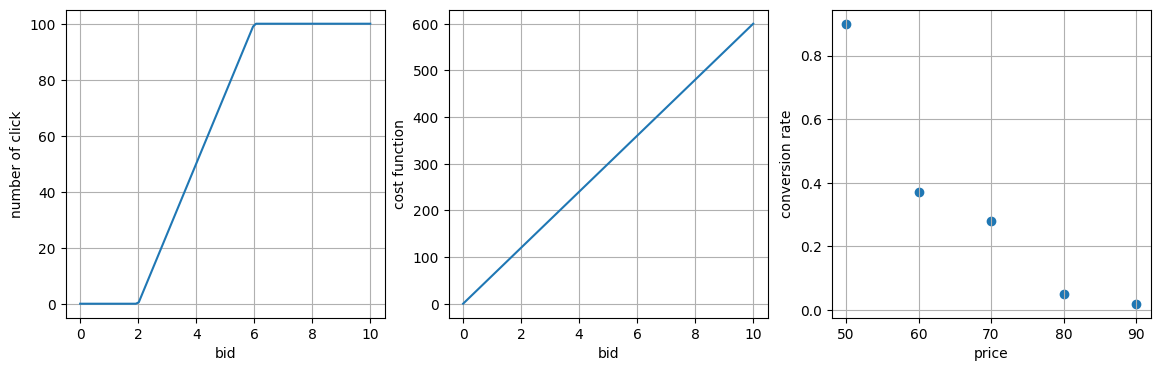

In [15]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.array([50, 60, 70, 80, 90])
plt.subplot(1,3,3)
plt.scatter(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

In [92]:
#Fixed parameters
n_arms = 5
T = 365

# in this step n_clicks and cost are given
# so let's fix a bid and compute n_clicks and cost
BID = 6
n_daily_clicks = int(C1.n_daily_clicks_function(BID))
cum_daily_costs = C1.cum_daily_costs_function(BID)

margin = 90
cost = 40

#setting the arms
prices = np.array([50,60,70,80,90])
opt_value = np.max(C1.conversion_rate_function(prices) * (prices - cost)) #optimal value of convertion rate between the arms
opt = n_daily_clicks * opt_value - cum_daily_costs


n_experiments = 1000

### UCB

In [93]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_conversion_rate_per_experiment = []
ucb_pulled_arms_counter_per_experiment = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(prices, cost, n_daily_clicks, cum_daily_costs, C1)
    ucb_learner = Custom_UCB_Learner(prices, n_daily_clicks, cum_daily_costs, cost)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    ucb_conversion_rate_per_experiment.append(ucb_learner.conversion_rate_learner.empirical_means)
    ucb_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in ucb_learner.rewards_per_arm])

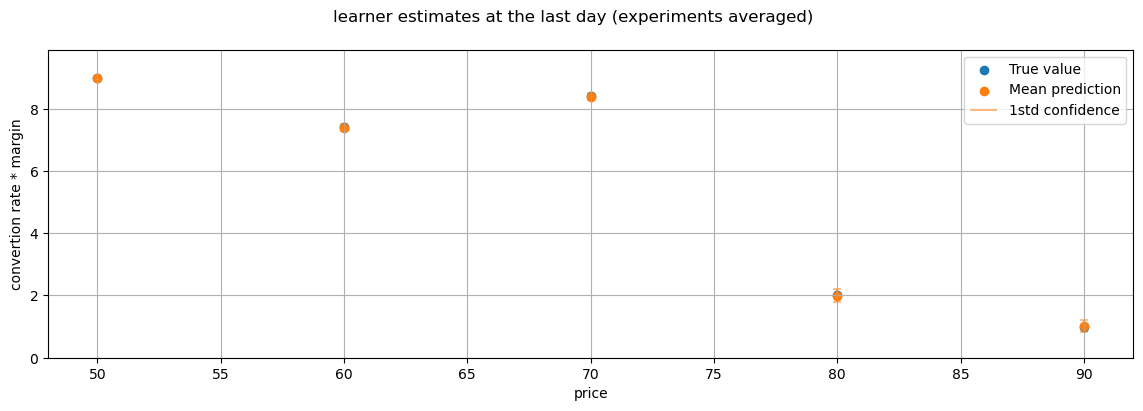

In [94]:
# Plot of the conversion rate

ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('learner estimates at the last day (experiments averaged)')

plt.scatter(prices, C1.conversion_rate_function(prices) * (prices - cost), label = "True value")
plt.scatter(prices, ucb_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(prices, ucb_conversion_rate_hat - ucb_conversion_rate_std, ucb_conversion_rate_hat +  ucb_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(prices, ucb_conversion_rate_hat - ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(prices, ucb_conversion_rate_hat + ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate * margin")
plt.ylim((0, 1.1*max(ucb_conversion_rate_hat)))
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

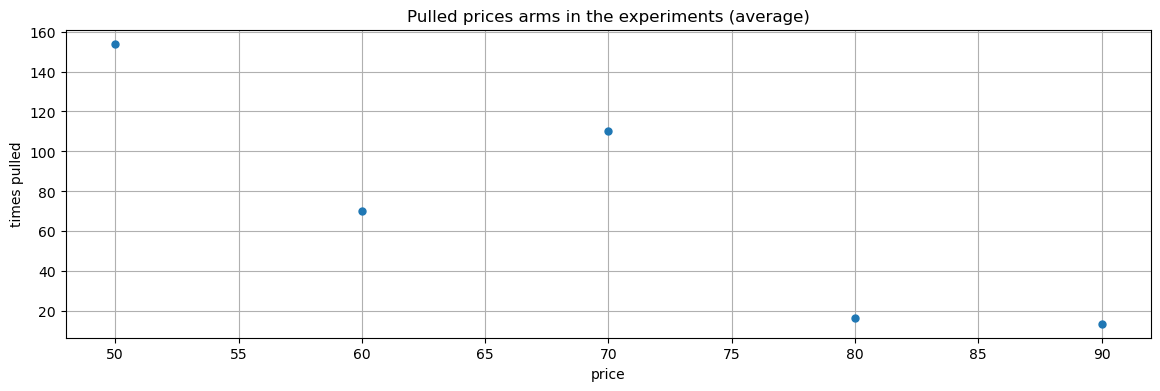

In [97]:
# plots pulled arms

#TODO: add something time related
zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)
# zz_std = np.std(ucb_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (14,4))

ax = fig.add_subplot(1,1,1)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(prices, zz, '.',  markersize = 10,color = "C0")

# plt.vlines(prices, zz - ucb_conversion_rate_std, zz +  ucb_conversion_rate_std,
#            colors='C0', alpha=0.5, label = "1std confidence")
# plt.scatter(prices, zz - ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
# plt.scatter(prices, zz + ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
plt.grid()

ax.set_xlabel('price')
ax.set_ylabel('times pulled')


### Thompson Sampling

In [107]:
## TS learner

ts_rewards_per_experiment = []

ts_conversion_rate_per_experiment = []
ts_pulled_arms_counter_per_experiment = [] 

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(prices, cost, n_daily_clicks, cum_daily_costs, C1)
    ts_learner = Custom_TS_Learner(prices, n_daily_clicks, cum_daily_costs, cost)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

    """ ts_conversion_rate_per_experiment.append(ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                              / (ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                                 + ts_learner.conversion_rate_learner.beta_parameters[:,1])) """
    ts_conversion_rate_per_experiment.append((ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                              / (ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                                 + ts_learner.conversion_rate_learner.beta_parameters[:,1])) * (prices - cost) )
    ts_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in ts_learner.rewards_per_arm])

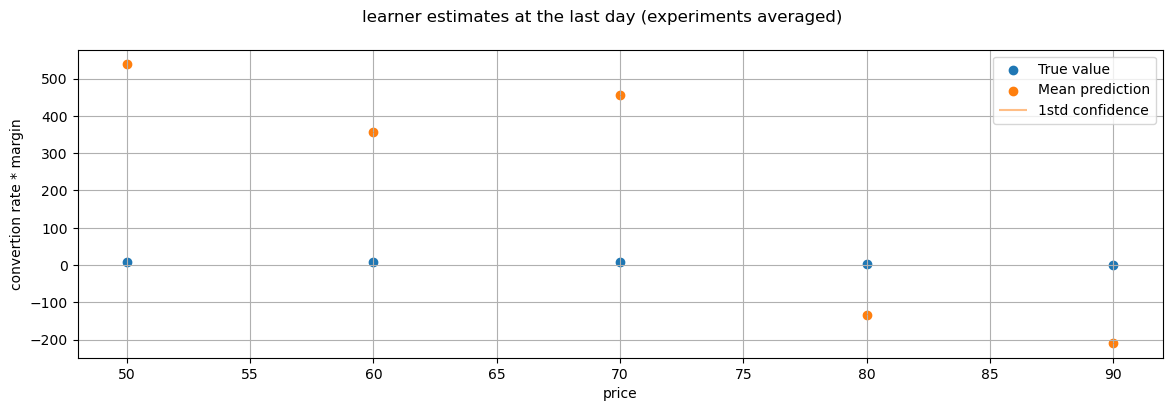

In [113]:
# Plot of the conversion rate

ts_conversion_rate_hat = np.mean(ts_conversion_rate_per_experiment, axis = 0) * n_daily_clicks - cum_daily_costs
ts_conversion_rate_std = np.std(ts_conversion_rate_per_experiment, axis = 0)



plt.figure(figsize = (14,4))
plt.suptitle('learner estimates at the last day (experiments averaged)')

plt.scatter(prices, C1.conversion_rate_function(prices) * (prices - cost), label = "True value")
plt.scatter(prices, ts_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(prices, ts_conversion_rate_hat - ts_conversion_rate_std, ts_conversion_rate_hat +  ts_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(prices, ts_conversion_rate_hat - ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(prices, ts_conversion_rate_hat + ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate * margin")
plt.legend()


# plt.ylim((0,1.1 * max(ts_conversion_rate_hat)))
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

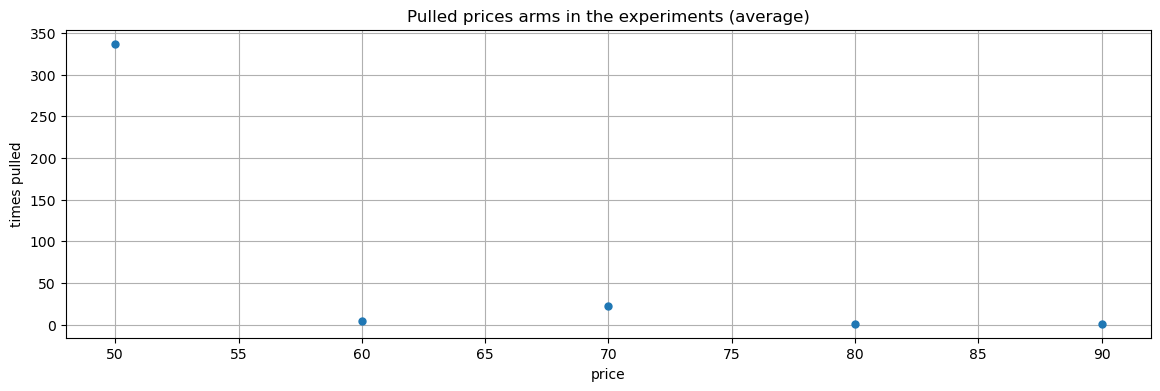

In [109]:
zz = np.mean(ts_pulled_arms_counter_per_experiment, axis = 0)
# zz_std = np.std(ucb_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (14,4))

ax = fig.add_subplot(1,1,1)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(prices, zz, '.',  markersize = 10,color = "C0")

# plt.vlines(prices, zz - ucb_conversion_rate_std, zz +  ucb_conversion_rate_std,
#            colors='C0', alpha=0.5, label = "1std confidence")
# plt.scatter(prices, zz - ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
# plt.scatter(prices, zz + ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
plt.grid()

ax.set_xlabel('price')
ax.set_ylabel('times pulled')

### Plots both methods

In [110]:
ucb_std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

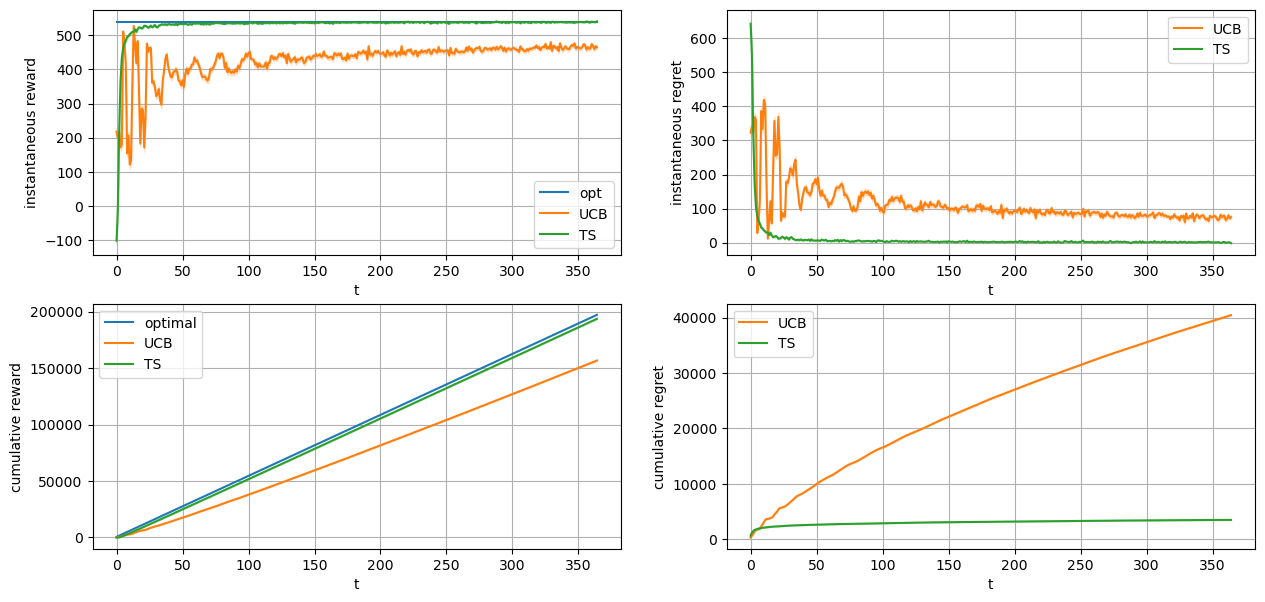

In [111]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

# Step 2

hp:
- just one class of users
- alpha is known
- n and c are unknown

OBS:I'm assuming that we can see both the number of clicks and the costs of the advertising (other than the reward)

About the learner: we are using 2 GP-Bandit learners one for the number of clicks and another one for the costs

### Environment

In [41]:
# class BiddingEnvironment:
#     def __init__(self, bids, user_class, sigma_clicks, sigma_costs):
#         """
#         n_arms: integer

#         prices: array
#             it is the set of prices we will use, since we are discretizing the problem
#             eg: an array of 5
#         """
#         # self.n_arms = len(bids)
#         self.bids = bids
#         self.user_class = user_class

#         self.mean_clicks = [user_class.n_daily_clicks_function(b) for b in bids]
#         self.mean_costs = [user_class.cum_daily_costs_function(b) for b in bids]

#         self.sigmas_clicks = np.ones(len(bids)) * sigma_clicks
#         self.sigmas_costs = np.ones(len(bids)) * sigma_costs


#     def round(self, margin, conversion_rate, pulled_arm):
#         #OBS:
#         n_daily_clicks = np.random.normal(self.mean_clicks[pulled_arm], self.sigmas_clicks[pulled_arm])
#         cum_daily_costs = np.random.normal(self.mean_costs[pulled_arm], self.sigmas_costs[pulled_arm])

#         alpha = conversion_rate # or "np.random.binomial(n_daily_clicks, conversion_rate)" ? imo this complicates the learning
#         reward = n_daily_clicks * alpha * margin - cum_daily_costs

#         return n_daily_clicks, cum_daily_costs, reward
    


    
class Environment:
    def __init__(self, bids, sigma_clicks, sigma_costs, conversion_rate, margin, user_class):
        self.userclass = user_class #obs:python should take by reference user_class, so it's always the same UserClass object
        self.margin = margin
        self.conversion_rate = conversion_rate

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, user_class)


    def round(self, pulled_arm):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm)
        reward = n_daily_clicks * self.conversion_rate * self.margin - cum_daily_costs
        # or  reward = np.random.binomial(n_daily_clicks, conversion_rate) * margin - cum_daily_cost  ??? 
        # Obviously this should incerease the variability

        return n_daily_clicks, cum_daily_costs, reward

### Learners

GPUCB

In [42]:
class Custom_GPUCB_Learner(Learner):
    def __init__(self, arms_bids, conversion_rate, margin):
        n_arms_bids = len(arms_bids)
        super().__init__(n_arms_bids)

        self.arms_bids = arms_bids

        self.conversion_rate = conversion_rate
        self.margin = margin

        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)


    def pull_arm(self):
        #upper bounds of clicks and lower bounds of costs
        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas

        upper_confidence = ub_clicks * self.conversion_rate * self.margin - lb_costs
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually the reward is computable: reward = n_daily_clicks * self.convertion_rate * self.margin - cum_daily_costs,
        #       but this assuming that the reward is in expectation wrt to conversion, 
        #       maybe it is reward = np.random.binomial(n_daily_clicks, self.convertion_rate) * self.margin - cum_daily_costs,
        #       (depends on what the environment does)
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.n_daily_clicks_learner.update(pulled_arm, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm, cum_daily_costs)

GPTS

In [44]:
class Custom_GPTS_Learner(Learner):
    def __init__(self, arms_bids, conversion_rate, margin):
        n_arms_bids = len(arms_bids)
        super().__init__(n_arms_bids)

        self.conversion_rate = conversion_rate
        self.margin = margin

        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)

    def pull_arm(self):
        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)

        alpha = self.conversion_rate
        idx = np.argmax(sampled_clicks * alpha * self.margin - sampled_costs)
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually the reward is computable: reward = n_daily_clicks * self.convertion_rate * self.margin - cum_daily_costs,
        #       but this assuming that the reward is in expectation wrt to conversion, 
        #       maybe it is reward = np.random.binomial(n_daily_clicks, self.convertion_rate) * self.margin - cum_daily_costs
        #       (depends on what the environment does)
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.n_daily_clicks_learner.update(pulled_arm, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm, cum_daily_costs)

## Example

In [45]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks

def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

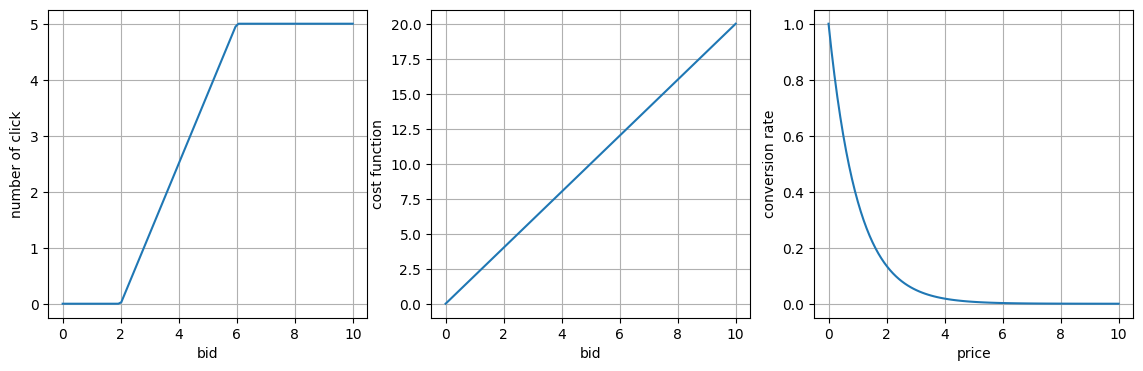

In [46]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

Parameters

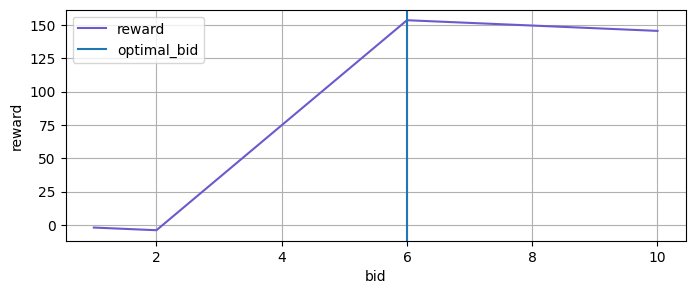

In [55]:
#Fixed parameters
T = 80#100#365

# in this step the optimal price for the conversion rate is given,
# so let's fix the price and compute the related conversion rate
PRICE = 1
conversion_rate = C1.conversion_rate_function(PRICE)

# margin
margin = 90

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)

rewards_on_arms = C1.n_daily_clicks_function(bids) * conversion_rate * margin - C1.cum_daily_costs_function(bids)
opt_arm = np.argmax(rewards_on_arms) #optimal value of convertion rate between the arms
opt = rewards_on_arms[opt_arm]




n_experiments = 50#20




plt.figure(figsize=(8,3))
plt.plot(bids, rewards_on_arms, "slateblue")
plt.axvline(bids[opt_arm])
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(["reward","optimal_bid"])
plt.grid(True)

### UCB

In [ ]:
## UCB learner

gpucb_rewards_per_experiment = []

ucb_n_daily_clicks_per_experiment = []
ucb_cum_daily_costs_per_experiment = []
ucb_pulled_arms_counter_per_experiment = [] #to count the arms that are pulled

# gpucb_n_daily_clicks_hat = np.zeros(len(bids))
# gpucb_n_daily_clicks_std = np.zeros(len(bids))
# gpucb_cum_daily_costs_hat = np.zeros(len(bids))
# gpucb_cum_daily_costs_std = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, sigma_clicks, sigma_costs, conversion_rate, margin, C1)
    gpucb_learner = Custom_GPUCB_Learner(bids,conversion_rate, margin)

    for t in range(0, T):
        pulled_arm = gpucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm)
        gpucb_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)
        
    gpucb_rewards_per_experiment.append(gpucb_learner.collected_rewards)

    ucb_n_daily_clicks_per_experiment.append(gpucb_learner.n_daily_clicks_learner.means)
    ucb_cum_daily_costs_per_experiment.append(gpucb_learner.cum_daily_costs_learner.means)
    ucb_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in gpucb_learner.rewards_per_arm])

    # mean_prediction, std_prediction = gpucb_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpucb_n_daily_clicks_hat += mean_prediction / n_experiments
    # gpucb_n_daily_clicks_std += std_prediction  / n_experiments

    # mean_prediction, std_prediction = gpucb_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpucb_cum_daily_costs_hat += mean_prediction / n_experiments
    # gpucb_cum_daily_costs_std += std_prediction  / n_experiments

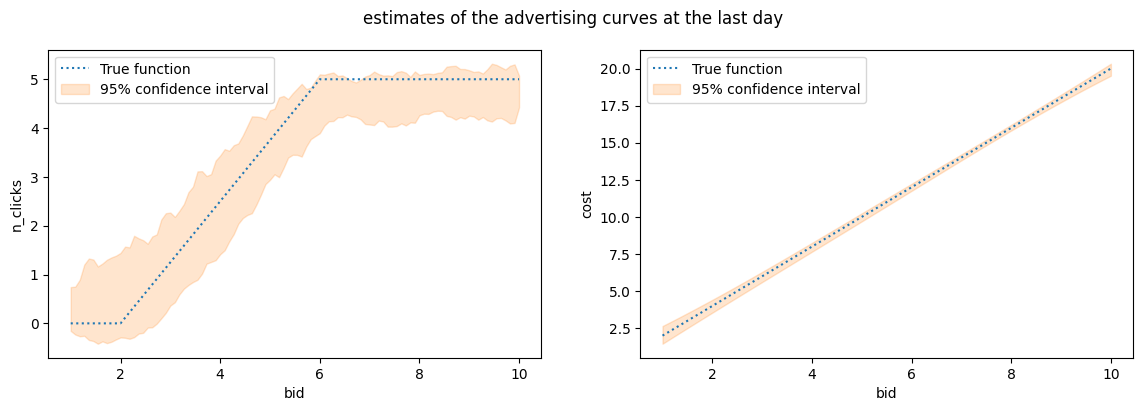

In [57]:
# Plots of the estimates of the functions clicks and costs at the last day

#OBS: This computes the CI using the std given by the GP
# plt.figure(figsize = (14,4))
# plt.suptitle('estimates of the advertising curves at the last day')

# plt.subplot(1,2,1)
# plt.plot(bids,C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
# # plt.plot(bids, gpucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpucb_n_daily_clicks_hat - 1.96 *gpucb_n_daily_clicks_std, gpucb_n_daily_clicks_hat + 1.96*gpucb_n_daily_clicks_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("n_clicks")
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(bids,C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
# # plt.plot(bids, gpucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpucb_cum_daily_costs_hat - 1.96 *gpucb_cum_daily_costs_std, gpucb_cum_daily_costs_hat + 1.96*gpucb_cum_daily_costs_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("cost")
# plt.legend()


#OBS: Here, the CI is wrt the experimental results
ucb_n_daily_clicks_hat = np.mean(ucb_n_daily_clicks_per_experiment, axis = 0)
ucb_n_daily_clicks_std = np.std(ucb_n_daily_clicks_per_experiment, axis = 0)

ucb_cum_daily_costs_hat = np.mean(ucb_cum_daily_costs_per_experiment, axis = 0)
ucb_cum_daily_costs_std = np.std(ucb_cum_daily_costs_per_experiment, axis = 0)



plt.figure(figsize = (14,4))
plt.suptitle('estimates of the confidence interval at the last day (experiments averaged)')

plt.subplot(1,2,1)
plt.plot(bids, C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_n_daily_clicks_hat - ucb_n_daily_clicks_std, ucb_n_daily_clicks_hat + ucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(bids, C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_cum_daily_costs_hat - ucb_cum_daily_costs_std, ucb_cum_daily_costs_hat +  ucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

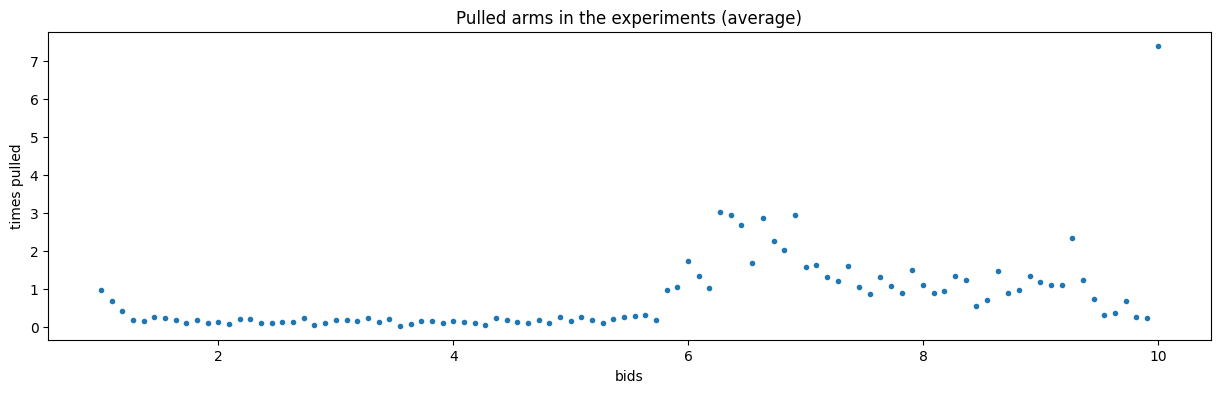

In [58]:

zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (15,4))

ax = fig.add_subplot()
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, zz, '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')
ax.grid()

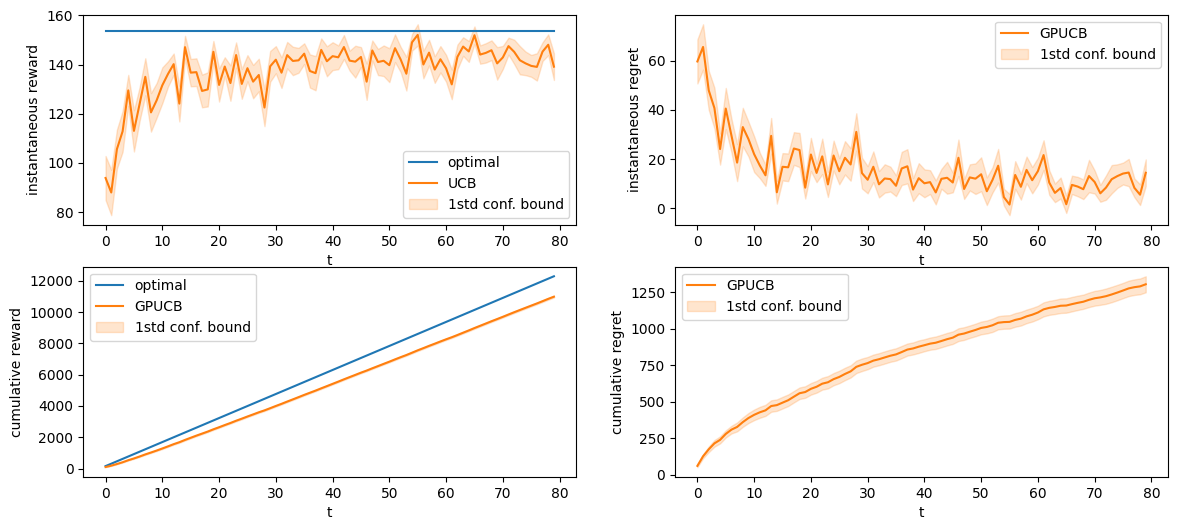

In [59]:
std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

### Thompson sampling

In [ ]:
## TS learner

gpts_rewards_per_experiment = []

ts_n_daily_clicks_per_experiment = []
ts_cum_daily_costs_per_experiment = []
ts_pulled_arms_counter_per_experiment = [] 

# gpts_n_daily_clicks_hat = np.zeros(len(bids))
# gpts_n_daily_clicks_std = np.zeros(len(bids))
# gpts_cum_daily_costs_hat = np.zeros(len(bids))
# gpts_cum_daily_costs_std = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, sigma_clicks, sigma_costs, conversion_rate, margin, C1)
    gpts_learner = Custom_GPTS_Learner(bids, conversion_rate, margin)

    for t in range(0, T):
        pulled_arm = gpts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

    ts_n_daily_clicks_per_experiment.append(gpts_learner.n_daily_clicks_learner.means)
    ts_cum_daily_costs_per_experiment.append(gpts_learner.cum_daily_costs_learner.means)
    ts_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in gpts_learner.rewards_per_arm])

    # mean_prediction, std_prediction = gpts_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpts_n_daily_clicks_hat += mean_prediction / n_experiments
    # gpts_n_daily_clicks_std += std_prediction  / n_experiments
    # mean_prediction, std_prediction = gpts_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpts_cum_daily_costs_hat += mean_prediction / n_experiments
    # gpts_cum_daily_costs_std += std_prediction  / n_experiments

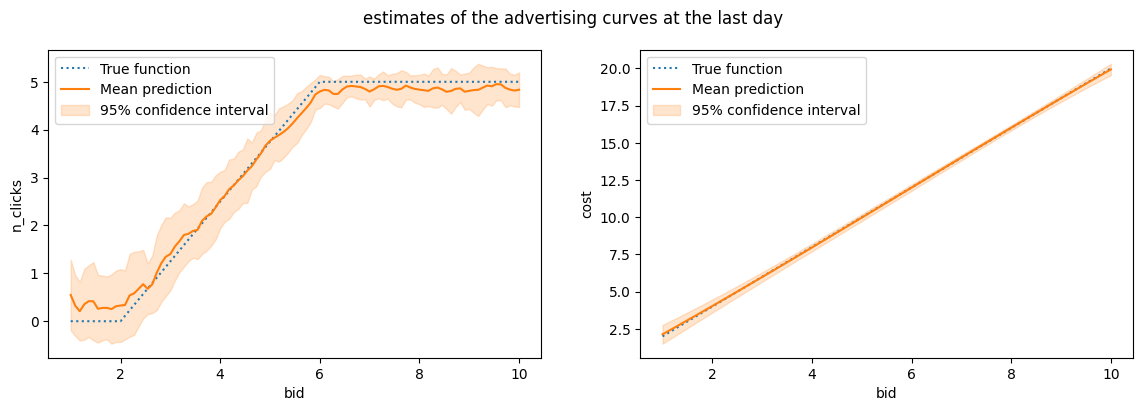

In [61]:
# Plots of the estimates of the functions clicks and costs at the last day

#OBS: This computes the CI using the std given by the GP
# plt.figure(figsize = (14,4))
# plt.suptitle('estimates of the advertising curves at the last day')

# plt.subplot(1,2,1)
# plt.plot(bids,C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, gpts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpts_n_daily_clicks_hat - 1.96 *gpts_n_daily_clicks_std, gpts_n_daily_clicks_hat + 1.96*gpts_n_daily_clicks_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("n_clicks")
# plt.legend()
# plt.grid()

# plt.subplot(1,2,2)
# plt.plot(bids,C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, gpts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpts_cum_daily_costs_hat - 1.96 *gpts_cum_daily_costs_std, gpts_cum_daily_costs_hat + 1.96*gpts_cum_daily_costs_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("cost")
# plt.legend()
# plt.grid()


#OBS: Here, the CI is wrt the experimental results
ts_n_daily_clicks_hat = np.mean(ts_n_daily_clicks_per_experiment, axis = 0)
ts_n_daily_clicks_std = np.std(ts_n_daily_clicks_per_experiment, axis = 0)

ts_cum_daily_costs_hat = np.mean(ts_cum_daily_costs_per_experiment, axis = 0)
ts_cum_daily_costs_std = np.std(ts_cum_daily_costs_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day (experiments averaged)')

plt.subplot(1,2,1)
plt.plot(bids, C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ts_n_daily_clicks_hat - ts_n_daily_clicks_std, ts_n_daily_clicks_hat + ts_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(bids, C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ts_cum_daily_costs_hat - ts_cum_daily_costs_std, ts_cum_daily_costs_hat +  ts_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

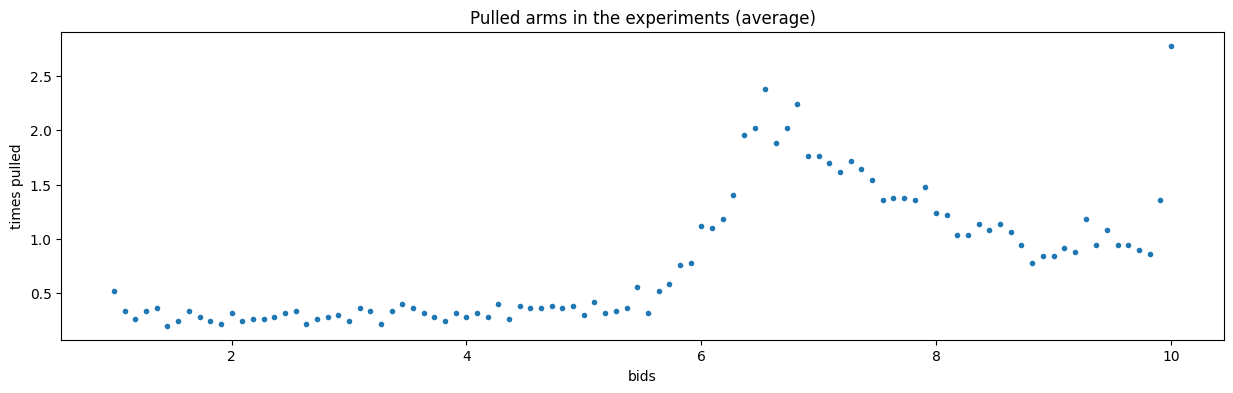

In [62]:
zz = np.mean(ts_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot()
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, zz, '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')
ax.grid()

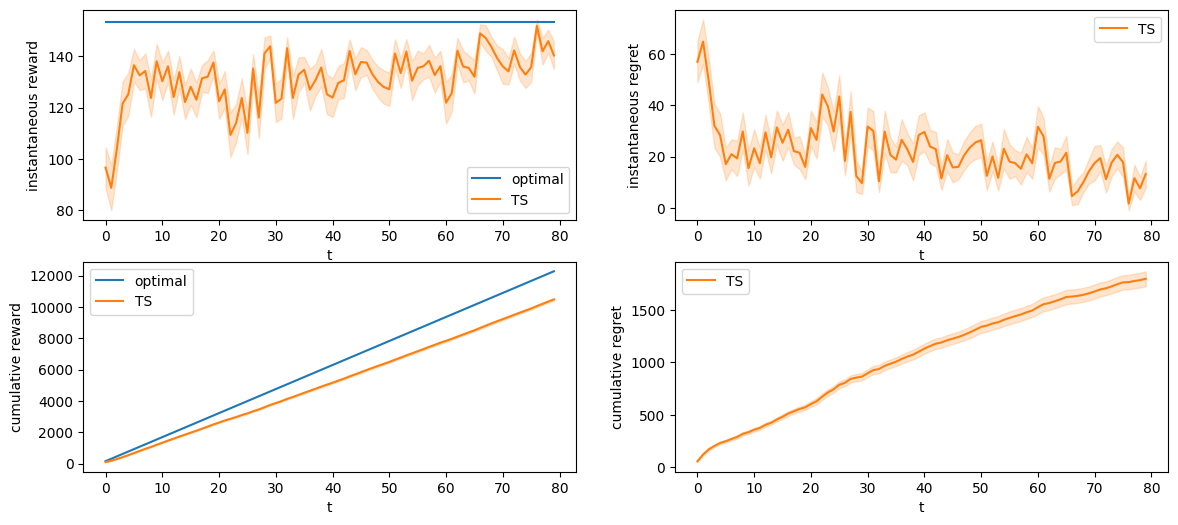

In [63]:
std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt))
plt.plot(mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["TS"])
plt.grid()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)))
plt.plot(np.cumsum(mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["TS"])
plt.grid()

### Plots both methods

In [64]:
ucb_std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

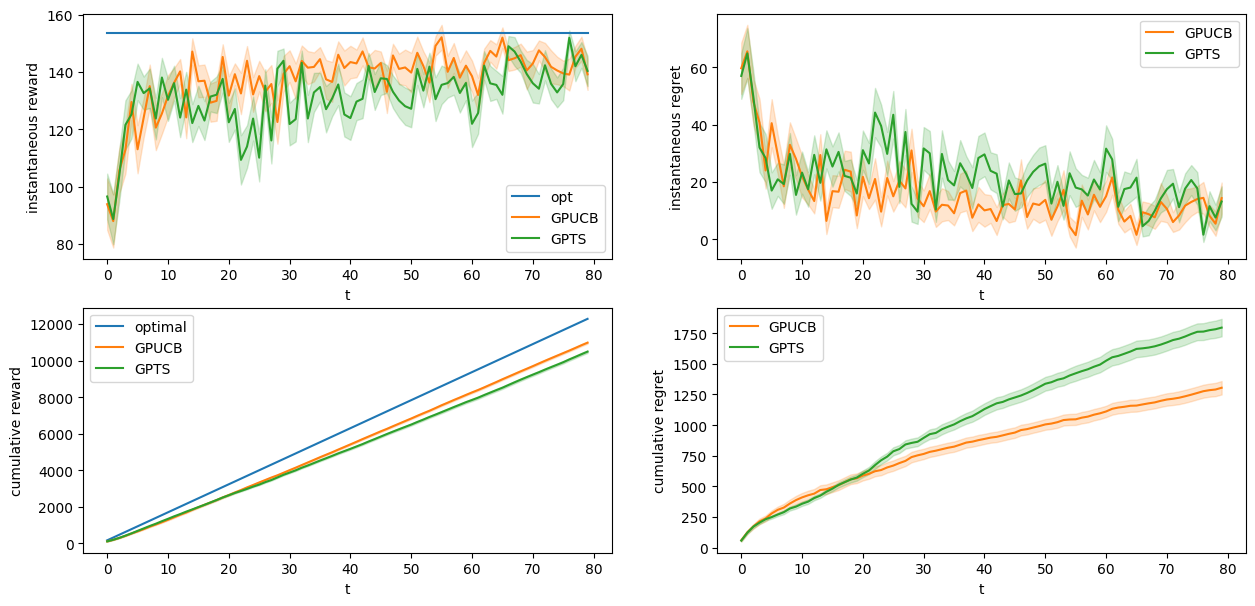

In [65]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "GPTS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

# Step 3

**Framework**:  
just one class,  
alpha, n and c are unknown

TODO:
- change confidence interval in TS plot (?)
- change data using step 0
- decide if more plots are needed

### Environment

In [30]:
class Environment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin, user_class):
        self.userclass = user_class

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, user_class)
        self.pricing_environment = PricingEnvironment(prices, margin, user_class)


    def round(self, pulled_arm_bid, pulled_arm_price):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm_bid)
        reward = self.pricing_environment.round(pulled_arm_price, n_daily_clicks, cum_daily_costs)

        return n_daily_clicks, cum_daily_costs, reward

## Learners

the reward function in expectation is  
reward(bid,price) = n_daily_clicks(bid) * alpha(price) * margin - cum_daily_costs(bid)

OBS:  
classic bandits for pricing  
GP bandits for advertising

### UCB based

In [31]:
class Custom_S3_UCB_Learner(Learner):# Obs: the curve of n_clicks and cost are always the same for any price we put, and the conversion rate is always the same for any bid we put
    def __init__(self, arms_bids, arms_prices, margin):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)] # Notation: reward is in rewards_per_arm[idx_bid][idx_price]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin = margin

        #learners:
        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)
        self.conversion_rate_learner = UCB1_Learner(n_arms_prices)


    def pull_arm(self):
        """
        Notes:
            The higher the conversion rate the higher the reward => I can pull directly the an arm of the prices for the highest alpha,
            while the clicks and costs I have to evaluate them together and pull the bid that maximizes the reward

            Question:
                Once I know the price arm to be pulled, for the bid arm, should I consider the upperbound of the conversion rate or just the mean of the conversion rate?
                -   choosing the mean of the conversion rate, there is just the uncertainty of related to the bid and the advertising curves
                -   choosing the upperbound of the conversion rate, it adds uncertainty related to the problem "conversion_rate(price)"
                --> I'm using the upperbound choice [but still an open question]
        """
        idx_price_arm = self.conversion_rate_learner.pull_arm()

        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas

        ub_convertion_rate = self.conversion_rate_learner.empirical_means[idx_price_arm] + self.conversion_rate_learner.confidence[idx_price_arm]

        upper_confidence = ub_clicks * ub_convertion_rate * self.margin - lb_costs
        idx_bid_arm = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])

        return (idx_bid_arm, idx_price_arm)


    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)


    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """

        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            alpha = (reward + cum_daily_costs) / (n_daily_clicks * self.margin)
            self.conversion_rate_learner.update(pulled_arm_price, alpha)
        else:
            self.conversion_rate_learner.t += 1# need to be increased, because t is used in the computation of the upperbound 

### TS based

In [32]:
class Custom_S3_TS_Learner(Learner):
    def __init__(self, arms_bids, arms_prices, margin):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids
        
        self.margin = margin

        #learners
        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)
        self.conversion_rate_learner = Binomial_TS_Learner(n_arms_prices)
        

    def pull_arm(self):
        sampled_conversion_rates = np.random.beta( self.conversion_rate_learner.beta_parameters[:,0], self.conversion_rate_learner.beta_parameters[:,1] )
        idx_price_arm = np.argmax(sampled_conversion_rates)

        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)
        
        alpha = sampled_conversion_rates[idx_price_arm]
        idx_bid_arm = np.argmax(sampled_clicks * alpha * self.margin - sampled_costs)
        
        return (idx_bid_arm, idx_price_arm)
    
    
    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)
        

    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            k = (reward + cum_daily_costs) / self.margin
            self.conversion_rate_learner.update(pulled_arm_price, k, n_daily_clicks)
        else:
            self.conversion_rate_learner.t += 1# need to be increased, because t is used in the computation of the upperbound 


## Example

In [33]:
F1 = 0
F2 = 0

def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max

    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks

def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

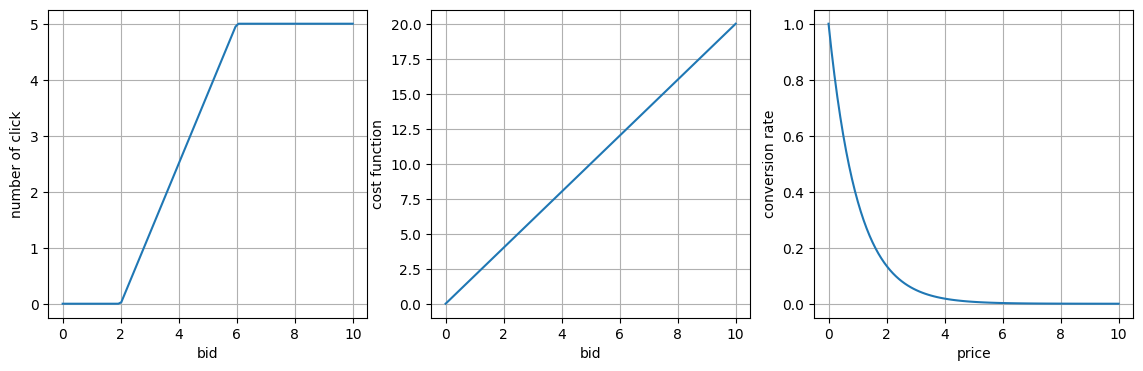

In [34]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

Parameters

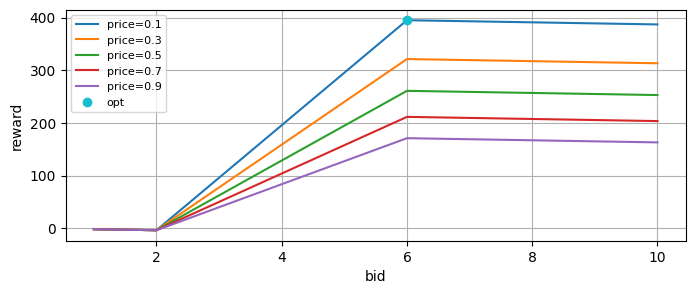

In [35]:
#Fixed parameters
T = 100 #365

# in this step the optimal price for the conversion rate is given,
# so let's fix the price and compute the releated conversion rate

# margin
margin = 90

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)
prices =  np.array([1,3,5,7,9]) / 10 #np.array([1,3,5,7,9])


opt_arm_price = np.argmax(C1.conversion_rate_function(prices)) #optimal value of conversion rate between the arms
opt_price = prices[opt_arm_price]

opt_conversion_rate = C1.conversion_rate_function(opt_price)

opt_bid_arm = np.argmax(C1.n_daily_clicks_function(bids) * opt_conversion_rate * margin - C1.cum_daily_costs_function(bids)) #optimal value of conversion rate between the arms
opt_bid = bids[opt_bid_arm]

opt_n_daily_clicks = C1.n_daily_clicks_function(opt_bid)
opt_cum_daily_costs = C1.cum_daily_costs_function(opt_bid)


opt = opt_n_daily_clicks * opt_conversion_rate * margin - opt_cum_daily_costs


n_experiments = 50


#Plot

plt.figure(figsize=(8,3))
for price in prices:
    plt.plot(bids, C1.n_daily_clicks_function(bids) * C1.conversion_rate_function(price) * margin - C1.cum_daily_costs_function(bids), label = f'price={price}')
plt.plot(opt_bid, opt, 'o', color = "C9", label = "opt")
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(fontsize=8)
plt.grid(True)

### UCB

In [ ]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_n_daily_clicks_per_experiment = []
ucb_cum_daily_costs_per_experiment = []
ucb_conversion_rate_per_experiment = []
ucb_pulled_arms_counter_per_experiment = [] #to count the arms that are pulled

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, C1)
    ucb_learner = Custom_S3_UCB_Learner(bids, prices, margin)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm_bid, pulled_arm_price)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward)


    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    ucb_n_daily_clicks_per_experiment.append(ucb_learner.n_daily_clicks_learner.means)
    ucb_cum_daily_costs_per_experiment.append(ucb_learner.cum_daily_costs_learner.means)
    ucb_conversion_rate_per_experiment.append(ucb_learner.conversion_rate_learner.empirical_means)
    ucb_pulled_arms_counter_per_experiment.append([[len(rewards_ij) for rewards_ij in rewards_i] for rewards_i in ucb_learner.rewards_per_arm])

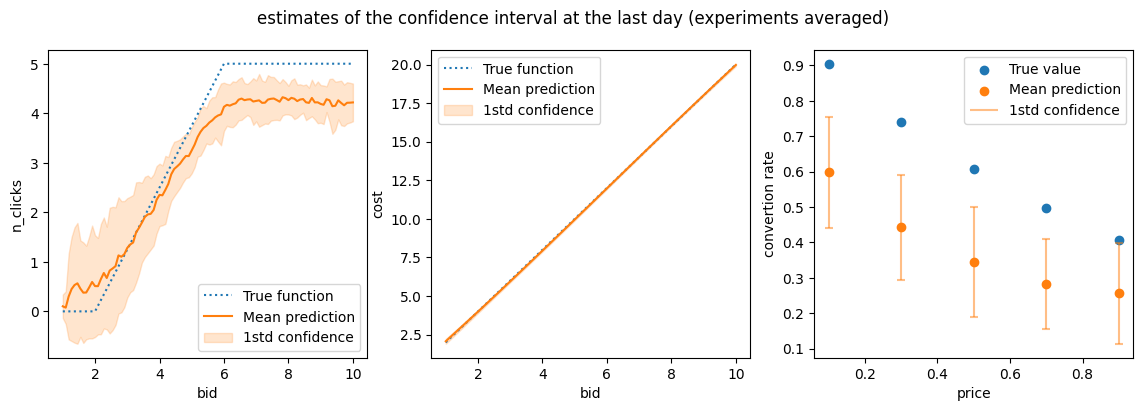

In [32]:
## Plots of the estimates of the functions clicks and costs at the last day
#TODO change the confidence and add something time related
ucb_n_daily_clicks_hat = np.mean(ucb_n_daily_clicks_per_experiment, axis = 0)
ucb_n_daily_clicks_std = np.std(ucb_n_daily_clicks_per_experiment, axis = 0)

ucb_cum_daily_costs_hat = np.mean(ucb_cum_daily_costs_per_experiment, axis = 0)
ucb_cum_daily_costs_std = np.std(ucb_cum_daily_costs_per_experiment, axis = 0)

ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the confidence interval at the last day (experiments averaged)')

plt.subplot(1,3,1)
plt.plot(bids, C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_n_daily_clicks_hat - ucb_n_daily_clicks_std, ucb_n_daily_clicks_hat + ucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,3,2)
plt.plot(bids, C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_cum_daily_costs_hat - ucb_cum_daily_costs_std, ucb_cum_daily_costs_hat +  ucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

plt.subplot(1,3,3)
plt.scatter(prices, C1.conversion_rate_function(prices), label = "True value")
plt.scatter(prices, ucb_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(prices, ucb_conversion_rate_hat - ucb_conversion_rate_std, ucb_conversion_rate_hat +  ucb_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(prices, ucb_conversion_rate_hat - ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(prices, ucb_conversion_rate_hat + ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.legend()

In [ ]:
#TODO: add something time related
zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(2,2,2)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(prices, np.sum(zz, axis = 0), '.', color = "C0")
ax.set_xlabel('price')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(2,2,4)
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, np.sum(zz, axis = 1), '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(1,2,1, projection='3d')
for i,bid in enumerate(bids):
    for j,price in enumerate(prices):
        ax.scatter(bid, price, zz[i,j], marker = '.', color = f'C{j}')#color = 'C0'
ax.set_title('Pulled arms in the experiments (average)', y = 0.96)
ax.view_init(18, -113)
ax.set_xlabel('bid')
ax.set_ylabel('price')
ax.set_zlabel('times pulled')
ax.set_box_aspect(aspect=(1.2,1,1), zoom=1)

fig.subplots_adjust(wspace = 0.05, hspace = 0.5)#left=None, bottom=-.1, right=None, top=1.1,

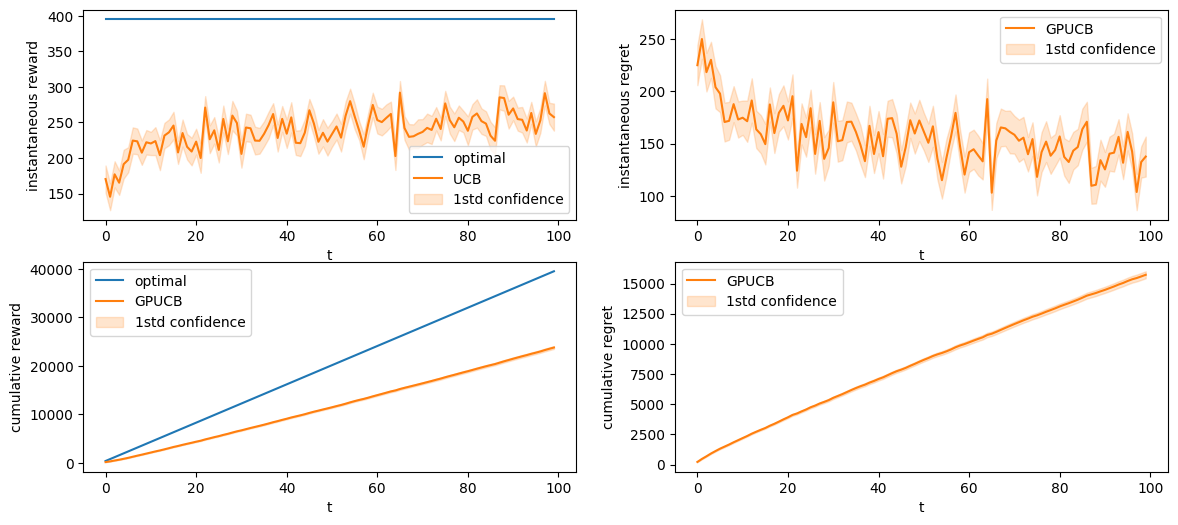

In [35]:
std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS

In [ ]:
## TS learner

ts_rewards_per_experiment = []

ts_n_daily_clicks_per_experiment = []
ts_cum_daily_costs_per_experiment = []
ts_conversion_rate_per_experiment = []
ts_pulled_arms_counter_per_experiment = [] 

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, C1)
    ts_learner = Custom_S3_TS_Learner(bids, prices, margin)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm_bid, pulled_arm_price)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts_n_daily_clicks_per_experiment.append(ts_learner.n_daily_clicks_learner.means)
    ts_cum_daily_costs_per_experiment.append(ts_learner.cum_daily_costs_learner.means)
    ts_conversion_rate_per_experiment.append(ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                              / (ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                                 + ts_learner.conversion_rate_learner.beta_parameters[:,1]))
    ts_pulled_arms_counter_per_experiment.append([[len(rewards_ij) for rewards_ij in rewards_i] for rewards_i in ts_learner.rewards_per_arm])

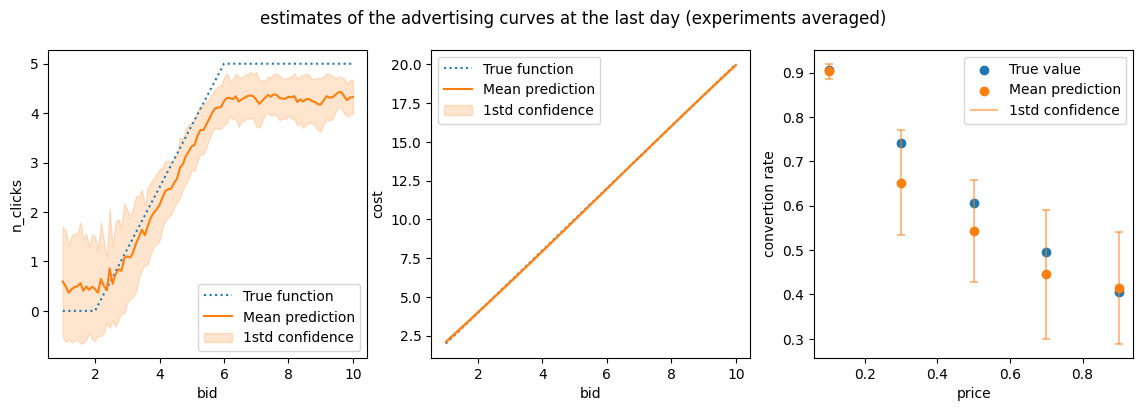

In [37]:
## Plots of the estimates of the functions clicks and costs at the last day
#TODO change the confidence and add something time related

ts_n_daily_clicks_hat = np.mean(ts_n_daily_clicks_per_experiment, axis = 0)
ts_n_daily_clicks_std = np.std(ts_n_daily_clicks_per_experiment, axis = 0)

ts_cum_daily_costs_hat = np.mean(ts_cum_daily_costs_per_experiment, axis = 0)
ts_cum_daily_costs_std = np.std(ts_cum_daily_costs_per_experiment, axis = 0)

ts_conversion_rate_hat = np.mean(ts_conversion_rate_per_experiment, axis = 0)
ts_conversion_rate_std = np.std(ts_conversion_rate_per_experiment, axis = 0)


#ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
#ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day (experiments averaged)')

plt.subplot(1,3,1)
plt.plot(bids, C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ts_n_daily_clicks_hat - ts_n_daily_clicks_std, ts_n_daily_clicks_hat + ts_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,3,2)
plt.plot(bids, C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ts_cum_daily_costs_hat - ts_cum_daily_costs_std, ts_cum_daily_costs_hat +  ts_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

plt.subplot(1,3,3)
plt.scatter(prices, C1.conversion_rate_function(prices), label = "True value")
plt.scatter(prices, ts_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(prices, ts_conversion_rate_hat - ts_conversion_rate_std, ts_conversion_rate_hat +  ts_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(prices, ts_conversion_rate_hat - ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(prices, ts_conversion_rate_hat + ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.legend()

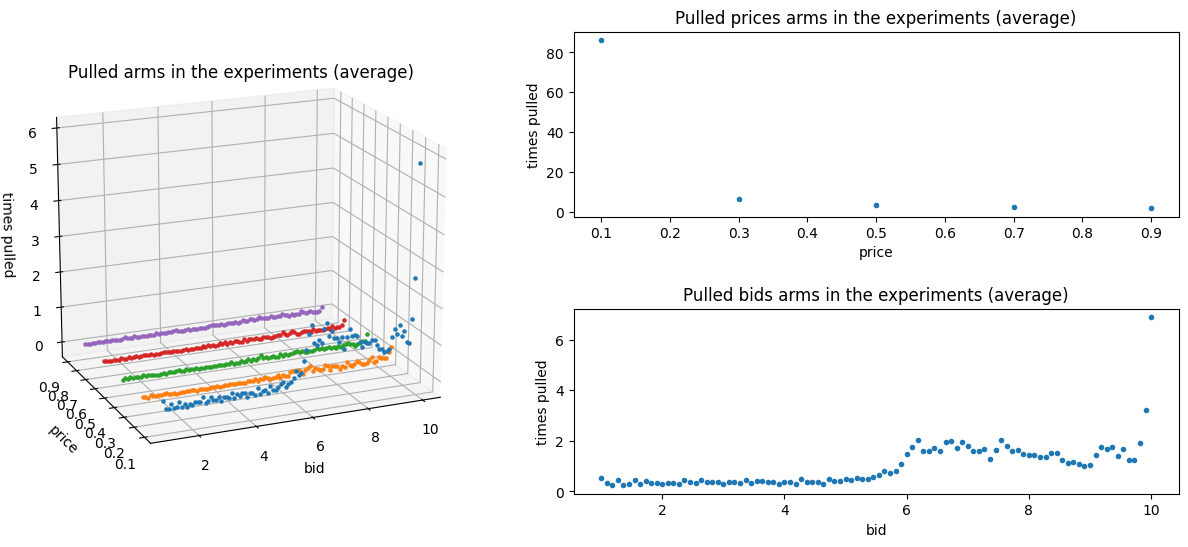

In [38]:
#TODO: add something time related
zz = np.mean(ts_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(2,2,2)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(prices, np.sum(zz, axis = 0), '.', color = "C0")
ax.set_xlabel('price')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(2,2,4)
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, np.sum(zz, axis = 1), '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(1,2,1, projection='3d')
for i,bid in enumerate(bids):
    for j,price in enumerate(prices):
        ax.scatter(bid, price, zz[i,j], marker = '.', color = f'C{j}')#color = 'C0'
ax.set_title('Pulled arms in the experiments (average)', y = 0.96)
ax.view_init(18, -113)
ax.set_xlabel('bid')
ax.set_ylabel('price')
ax.set_zlabel('times pulled')
ax.set_box_aspect(aspect=(1.2,1,1), zoom=1)

fig.subplots_adjust(wspace = 0.05, hspace = 0.5)#left=None, bottom=-.1, right=None, top=1.1,

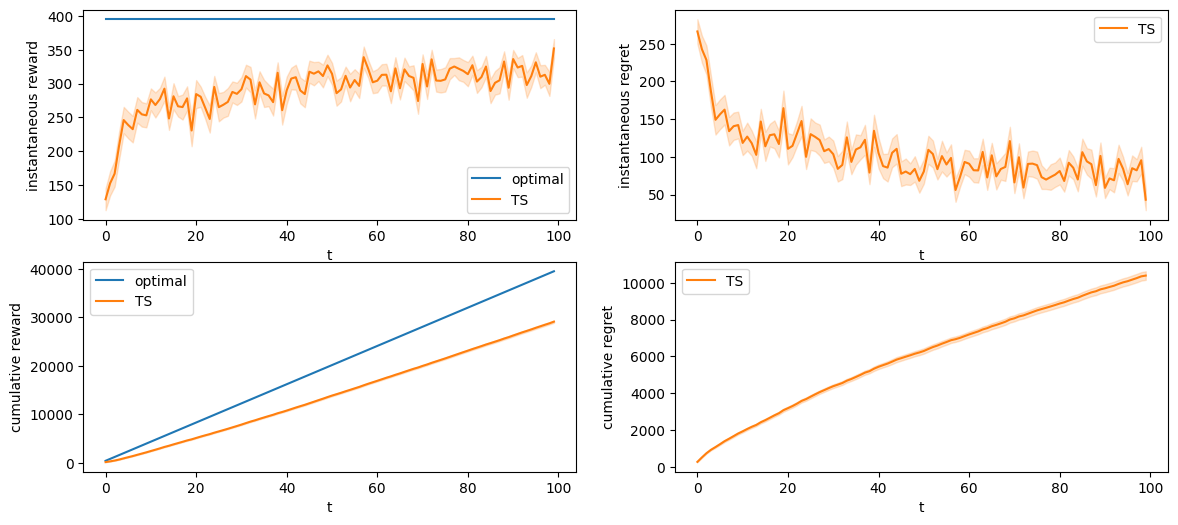

In [39]:
std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

#Starting Plots
plt.figure(figsize = (14,6))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

#Instantaneous regret plot
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat - std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

#Cumulative regret plot
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Comparing UCB and TS

In [37]:
## UCB
ucb_std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

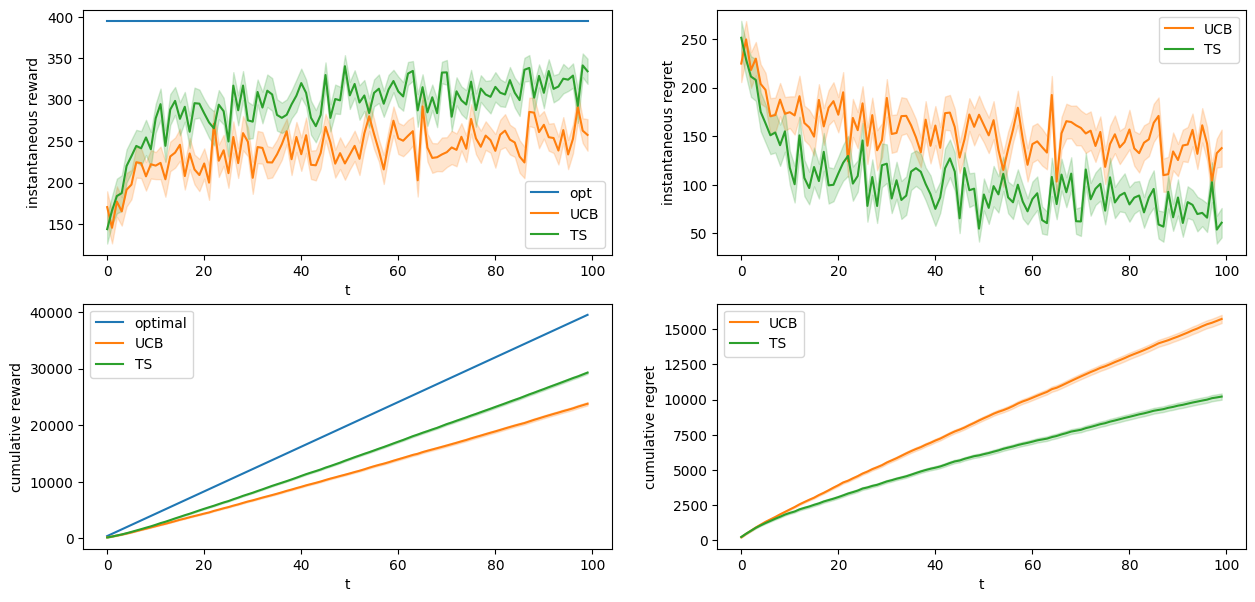

In [38]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

# Step 4

### Environment

In [10]:
#Obs: it is the same environment of step3, with self.user_class commented

class ContextEnvironment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin, user_class):
        # self.user_Class = user_class

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, user_class)
        self.pricing_environment = PricingEnvironment(prices, margin, user_class)


    def round(self, pulled_arm_bid, pulled_arm_price):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm_bid)
        reward = self.pricing_environment.round(pulled_arm_price, n_daily_clicks, cum_daily_costs)

        return n_daily_clicks, cum_daily_costs, reward

In [11]:
class Environment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin, user_classes):
        self.user_classes = user_classes
        self.n_classes = len(user_classes)

        self.single_environments = [ContextEnvironment(bids, prices, sigma_clicks, sigma_costs, margin, user_class) for user_class in user_classes]
        self.features_list = [(user_class.F1,user_class.F2) for user_class in user_classes]

    def round(self, pulled_arm_bid_list, pulled_arm_price_list, partition = [ [(0,0),(0,1),(1,0),(1,1)] ]):
        """
        pulled_arm_bid_list: list of integers
            idx of the pulled arm ob the bids for each component of the partition

        pulled_arm_price_list: list of integers
            idx of the pulled arm ob the prices for each component of the partition

        partition: list of lists of tuples of integers
            notation: each element must contain a tuple indicating the partitioning for the features F1 and F2
            e.g.
                if no partition ((the same as one set containing all possible features in the partition)): partition = [ [(0,0),(0,1),(1,0),(1,1)] ]
                if partition by splitting F1: partition = [ [(0,0),(0,1)] , [(1,0),(1,1)] ]

        Note: pulled_arm_bid_list, pulled_arm_price_list, partition must have the same length
        """

        n_daily_clicks_list = []
        cum_daily_costs_list = []
        reward_list = []
        for i in range(self.n_classes):
            user_F1 = self.user_classes[i].F1
            user_F2 = self.user_classes[i].F2

            idx_context = 0
            for context in partition:
                if (user_F1,user_F2) in context:
                    break
                idx_context += 1

            n_daily_clicks, cum_daily_costs, reward = self.single_environments[i].round(pulled_arm_bid_list[idx_context],
                                                                                        pulled_arm_price_list[idx_context])


            n_daily_clicks_list.append(n_daily_clicks)
            cum_daily_costs_list.append(cum_daily_costs)
            reward_list.append(reward)

        return n_daily_clicks_list, cum_daily_costs_list, reward_list, self.features_list

## Learners

hp:
- we assume that the features we observe are binary  
    e.g. if we have 2 features: (0,0), (0,1), (1,0), (1,1) are the all the possible observations

### UCB

In [10]:
"""
Com: It is like of the Custom_S3_UCB_Learner with the following modifications:

Modifications:
- new attribute: context
- new method: update_from_batch
"""

class UCB_SingleContextLearner(Learner):# Obs: the curve of n_clicks and cost are always the same for any price we put, and the conversion rate is always the same for any bid we put
    def __init__(self, arms_bids, arms_prices, margin, context):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)] # Notation: reward is in rewards_per_arm[idx_bid][idx_price]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin = margin

        #learners:
        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)
        self.conversion_rate_learner = UCB1_Learner(n_arms_prices)

        self.context = context# it is a list of tuples #


    def pull_arm(self):
        """
        Notes:
            The higher the conversion rate the higher the reward => I can pull directly the an arm of the prices for the highest alpha,
            while the clicks and costs I have to evaluate them together and pull the bid that maximizes the reward

            Question:
                Once I know the price arm to be pulled, for the bid arm, should I consider the upperbound of the conversion rate or just the mean of the conversion rate?
                -   choosing the mean of the conversion rate, there is just the uncertainty of related to the bid and the advertising curves
                -   choosing the upperbound of the conversion rate, it adds uncertainty related to the problem "conversion_rate(price)"
                --> I'm using the upperbound choice
        """
        idx_price_arm = self.conversion_rate_learner.pull_arm()

        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas

        ub_convertion_rate = self.conversion_rate_learner.empirical_means[idx_price_arm] + self.conversion_rate_learner.confidence[idx_price_arm]

        upper_confidence = ub_clicks * ub_convertion_rate * self.margin - lb_costs
        idx_bid_arm = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])

        return (idx_bid_arm, idx_price_arm)


    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)


    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            alpha = (reward + cum_daily_costs) / (n_daily_clicks * self.margin)
            self.conversion_rate_learner.update(pulled_arm_price, alpha)
        else:
            self.conversion_rate_learner.t += 1# need to be increased, because t is used in the computation of the upperbound


    def update_from_batch(self, pulled_arm_bid_data, pulled_arm_price_data, n_daily_clicks_data, cum_daily_costs_data, reward_data, time):
        """Obs:
            - not all rewards are valid to update the convertion rate, because n_clicks can be 0 in some of values in n_daily_clicks_data
        """
        arms_of_alphas = []
        alphas = []
        for i, reward in enumerate(reward_data):
            self.update_observations(pulled_arm_bid_data[i], pulled_arm_price_data[i], reward)
            if n_daily_clicks_data[i] > 0:
                arms_of_alphas.append(pulled_arm_price_data[i])
                alphas.append((reward + cum_daily_costs_data[i]) / (n_daily_clicks_data[i] * self.margin))

        self.conversion_rate_learner.update_from_batch(arms_of_alphas, alphas, time)
        self.n_daily_clicks_learner.update_from_batch(pulled_arm_bid_data, n_daily_clicks_data, time)
        self.cum_daily_costs_learner.update_from_batch(pulled_arm_bid_data, cum_daily_costs_data, time)
        self.t += time


In [ ]:
class UCB_FixedContextsLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin, contexts):
        super().__init__(0)# This learner learns by context and not by arms directly (the arms are inside the context_learners).

        self.collected_n_daily_clicks = []
        self.collected_cum_daily_costs = []
        self.collected_features = []

        self.n_arms_bids = len(arms_bids)
        self.n_arms_prices = len(arms_prices)
        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin = margin
        self.contexts = contexts

        # Learners:
        self.context_learners = [UCB_SingleContextLearner(arms_bids, arms_prices, margin, context) for context in self.contexts]


    def pull_arm(self):
        idx_bid_arm_list = []
        idx_price_arm_list = []
        for context_learner in self.context_learners:
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            idx_bid_arm_list.append(idx_bid_arm)
            idx_price_arm_list.append(idx_price_arm)

        return (idx_bid_arm_list, idx_price_arm_list, self.contexts)


    def update_observations(self, n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list):
        # no self.rewards_per_arm[pulled_arm].append(reward) because no concept of an arm (the arms are used inside the context learners)
        self.collected_rewards.append(reward_list)
        self.collected_n_daily_clicks.append(n_daily_clicks_list)
        self.collected_cum_daily_costs.append(cum_daily_costs_list)
        self.collected_features.append(features_list)
        

    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list):
        """Obs: the length of the lists of the pulled arms are not necessary equal to those in the lists of clicks, costs, rewards and features"""
        self.t += 1
        self.update_observations(n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list)

        for i,_ in enumerate(self.contexts):
            pulled_arm_bid_data = [pulled_arm_bid_list[i]] * len(features_list)
            pulled_arm_price_data = [pulled_arm_price_list[i]] * len(features_list)

            n_daily_clicks_data = []
            cum_daily_costs_data = []
            reward_data = []
            for j,_ in enumerate(features_list):
                n_daily_clicks_data.append(n_daily_clicks_list[j])
                cum_daily_costs_data.append(cum_daily_costs_list[j])
                reward_data.append(reward_list[j])

            self.context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                            n_daily_clicks_data, cum_daily_costs_data, reward_data, 1)

In [ ]:
class UCB_ContextsGreadyLearner(UCB_FixedContextsLearner):
    def __init__(self, arms_bids, arms_prices, margin, window_context):

        # self.n_features = 2
        contexts = [ [(0,0),(0,1),(1,0),(1,1)] ] # i.e. just one contexts containing all the possible combinations of features
        super().__init__(arms_bids, arms_prices, margin, contexts)
        # self.features_partitioned = np.zeros(self.n_features)#notation 0 if that feature is not related to the partition, 1 if it is

        self.window_context = window_context

        # we need
        self.collected_pulled_arm_bid = []# to save the idx of the pulled arms ordered by features not by context
        self.collected_pulled_arm_price = []# to save the idx of the pulled arms ordered by features not by context
        #COM: we need to collect all these informations because they are used when a new context structure is built


    # def pull_arm(self): the same of the super class

    def collect_pulled_arms(self, pulled_arm_bid_list, pulled_arm_price_list, features_list):
        idx_bid_list = []#[[] for fts in features_list]
        idx_price_list =  []#[[] for fts in features_list]

        for fts in features_list:#i,fts in enumerate(features_list):
            for j,context in enumerate(self.contexts):
                if fts in context:
                    # idx_bid_list[i] = pulled_arm_bid_list[j]
                    # idx_price_list[i] = pulled_arm_price_list[j]
                    idx_bid_list.append(pulled_arm_bid_list[j])
                    idx_price_list.append(pulled_arm_price_list[j])
                    break

        self.collected_pulled_arm_bid.append(idx_bid_list)
        self.collected_pulled_arm_price.append(idx_price_list)


    def get_total_lb_from_contexts(self, context_learners):
        lb_reward_tot = 0
        for context_learner in context_learners:
            lb_clicks = min(context_learner.n_daily_clicks_learner.means - context_learner.n_daily_clicks_learner.sigmas)
            lb_convertion_rate = min(context_learner.conversion_rate_learner.empirical_means - context_learner.conversion_rate_learner.confidence)
            ub_costs = max(context_learner.cum_daily_costs_learner.means + context_learner.cum_daily_costs_learner.sigmas)

            lb_reward = lb_clicks * lb_convertion_rate * self.margin - ub_costs
            lb_reward_tot += lb_reward
        return lb_reward_tot


    def generate_partitions(self):
        """Greedy approach:
        returns a list of the partitions to be evaluated
        """
        ## General approach if n_features = any number ??
        # something that uses self.features_partitioned and self.contexts to generate the partitions
        # and return the partitions and the indicators of which features are used for those partitions
        #
        # since n_features = 2 it is just:
        partitions_list = []
        if len(self.contexts) == 1:
            partitions_list = [ [[(0,0),(0,1)], [(1,0),(1,1)]], [[(0,0),(1,0)], [(0,1),(1,1)]] ]
        if len(self.contexts) == 2:
            partitions_list = [ [[(0,0)], [(0,1)], [(1,0)], [(1,1)]] ]
        if len(self.contexts) == 4:
            partitions_list = []

        return partitions_list


    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list):
        """Obs: length of the lists of the pulled arms not necessary equal to those in the lists of clicks costs rewards and features"""

        super().update(pulled_arm_bid_list, pulled_arm_price_list, n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list)
        self.collect_pulled_arms(pulled_arm_bid_list, pulled_arm_price_list, features_list)

        if self.t % self.window_context == 0: #then consider to change the structure of the contexts
            lb_reward_current_partition = self.get_total_lb_from_contexts(self.context_learners)
            partitions_to_evaluate = self.generate_partitions()

            for partition in partitions_to_evaluate:
                new_context_learners = [UCB_SingleContextLearner(self.arms_bids, self.arms_prices, self.margin, context) for context in partition]

                for i,context in enumerate(partition):
                    # finding the data to fit the context learner:
                    pulled_arm_bid_data = []
                    pulled_arm_price_data = []
                    n_daily_clicks_data = []
                    cum_daily_costs_data = []
                    reward_data = []
                    for t, collected_features_t in enumerate(self.collected_features):
                        for j, fts in enumerate(collected_features_t):
                            if fts in context:
                                pulled_arm_bid_data.append(self.collected_pulled_arm_bid[t][j])
                                pulled_arm_price_data.append(self.collected_pulled_arm_price[t][j])

                                n_daily_clicks_data.append(self.collected_n_daily_clicks[t][j])
                                cum_daily_costs_data.append(self.collected_cum_daily_costs[t][j])
                                reward_data.append(self.collected_rewards[t][j])

                    # fitting the context learner
                    new_context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                              n_daily_clicks_data, cum_daily_costs_data, reward_data, self.t)
                                                              
                ## evaluate lower bound of the new partition
                lb_reward_new_partition = self.get_total_lb_from_contexts(new_context_learners)

                # Now we need to compare this lb with the lb of the current partition to choose which is better
                if lb_reward_new_partition > lb_reward_current_partition:
                    self.contexts = partition.copy()
                    self.context_learners = new_context_learners
                    lb_reward_current_partition = lb_reward_new_partition

                    print(f'PARTITION CHANGED AT TIME {self.t}')


### TS

In [12]:
"""
Com: It is like of the Custom_S3_TS_Learner with the following modifications:

Modifications:
- new attribute: context (actually, not really necesary)
- new method: update_from_batch
"""

class TS_SingleContextLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin, context):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids
        
        self.margin = margin

        #learners
        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)
        self.conversion_rate_learner = Binomial_TS_Learner(n_arms_prices)

        self.context = context# it is a list of tuples #
        

    def pull_arm(self):
        sampled_conversion_rates = np.random.beta( self.conversion_rate_learner.beta_parameters[:,0], self.conversion_rate_learner.beta_parameters[:,1] )
        idx_price_arm = np.argmax(sampled_conversion_rates)

        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)
        
        alpha = sampled_conversion_rates[idx_price_arm]
        idx_bid_arm = np.argmax(sampled_clicks * alpha * self.margin - sampled_costs)
        
        return (idx_bid_arm, idx_price_arm)
    
    
    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)
        

    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            k = (reward + cum_daily_costs) / self.margin
            self.conversion_rate_learner.update(pulled_arm_price, k, n_daily_clicks)
        else:
            self.conversion_rate_learner.t += 1# need to be increased, because t is used in the computation of the upperbound 


    def update_from_batch(self, pulled_arm_bid_data, pulled_arm_price_data, n_daily_clicks_data, cum_daily_costs_data, reward_data, time):
        """Obs:
            - not all rewards are valid to update the convertion rate, because n_clicks can be 0 in some of values in n_daily_clicks_data
        """
        arms_data = []
        k_data = []
        k_max_data = []
        for i, reward in enumerate(reward_data):
            self.update_observations(pulled_arm_bid_data[i], pulled_arm_price_data[i], reward)
            if n_daily_clicks_data[i] > 0:
                arms_data.append(pulled_arm_price_data[i])
                k_max_data.append(n_daily_clicks_data[i])
                k_data.append((reward + cum_daily_costs_data[i]) / self.margin)

        self.conversion_rate_learner.update_from_batch(arms_data, k_data, k_max_data, time)
        self.n_daily_clicks_learner.update_from_batch(pulled_arm_bid_data, n_daily_clicks_data, time)
        self.cum_daily_costs_learner.update_from_batch(pulled_arm_bid_data, cum_daily_costs_data, time)
        self.t += time

In [13]:
class TS_FixedContextsLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin, contexts):
        super().__init__(0)# This learner learns by context and not by arms directly (the arms are inside the context_learners).

        self.collected_n_daily_clicks = []
        self.collected_cum_daily_costs = []
        self.collected_features = []

        self.n_arms_bids = len(arms_bids)
        self.n_arms_prices = len(arms_prices)
        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin = margin
        self.contexts = contexts

        # Learners:
        self.context_learners = [TS_SingleContextLearner(arms_bids, arms_prices, margin, context) for context in self.contexts]


    def pull_arm(self):
        idx_bid_arm_list = []
        idx_price_arm_list = []
        for context_learner in self.context_learners:
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            idx_bid_arm_list.append(idx_bid_arm)
            idx_price_arm_list.append(idx_price_arm)

        return (idx_bid_arm_list, idx_price_arm_list, self.contexts)


    def update_observations(self, n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list):
        # no self.rewards_per_arm[pulled_arm].append(reward) because no concept of an arm (the arms are used inside the context learners)
        self.collected_rewards.append(reward_list)
        self.collected_n_daily_clicks.append(n_daily_clicks_list)
        self.collected_cum_daily_costs.append(cum_daily_costs_list)
        self.collected_features.append(features_list)
        

    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list):
        """Obs: the length of the lists of the pulled arms are not necessary equal to those in the lists of clicks, costs, rewards and features"""
        self.t += 1
        self.update_observations(n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list)

        for i,_ in enumerate(self.contexts):
            pulled_arm_bid_data = [pulled_arm_bid_list[i]] * len(features_list)
            pulled_arm_price_data = [pulled_arm_price_list[i]] * len(features_list)

            n_daily_clicks_data = []
            cum_daily_costs_data = []
            reward_data = []
            for j,_ in enumerate(features_list):
                n_daily_clicks_data.append(n_daily_clicks_list[j])
                cum_daily_costs_data.append(cum_daily_costs_list[j])
                reward_data.append(reward_list[j])

            self.context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                            n_daily_clicks_data, cum_daily_costs_data, reward_data, 1)

In [14]:
class TS_ContextsGreadyLearner(TS_FixedContextsLearner):
    def __init__(self, arms_bids, arms_prices, margin, window_context):

        # self.n_features = 2
        contexts = [ [(0,0),(0,1),(1,0),(1,1)] ] # i.e. just one contexts containing all the possible combinations of features
        super().__init__(arms_bids, arms_prices, margin, contexts)
        # self.features_partitioned = np.zeros(self.n_features)#notation 0 if that feature is not related to the partition, 1 if it is

        self.window_context = window_context

        # we need
        self.collected_pulled_arm_bid = []# to save the idx of the pulled arms ordered by features not by context
        self.collected_pulled_arm_price = []# to save the idx of the pulled arms ordered by features not by context
        #COM: we need to collect all these informations because they are used when a new context structure is built


    # def pull_arm(self): the same of the super class

    def collect_pulled_arms(self, pulled_arm_bid_list, pulled_arm_price_list, features_list):
        idx_bid_list = []#[[] for fts in features_list]
        idx_price_list =  []#[[] for fts in features_list]

        for fts in features_list:#i,fts in enumerate(features_list):
            for j,context in enumerate(self.contexts):
                if fts in context:
                    # idx_bid_list[i] = pulled_arm_bid_list[j]
                    # idx_price_list[i] = pulled_arm_price_list[j]
                    idx_bid_list.append(pulled_arm_bid_list[j])
                    idx_price_list.append(pulled_arm_price_list[j])
                    break

        self.collected_pulled_arm_bid.append(idx_bid_list)
        self.collected_pulled_arm_price.append(idx_price_list)


    def get_total_lb_from_contexts(self, context_learners):
        """OBS:
            - not really a lb, at least not from the mean and std. It is kind of a sampled lb
        """
        lb_reward_tot = 0
        for context_learner in context_learners:
            sampled_conversion_rates = np.random.beta( context_learner.conversion_rate_learner.beta_parameters[:,0], context_learner.conversion_rate_learner.beta_parameters[:,1] )
            sampled_clicks = np.random.normal(context_learner.n_daily_clicks_learner.means, context_learner.n_daily_clicks_learner.sigmas)
            sampled_costs = np.random.normal(context_learner.cum_daily_costs_learner.means, context_learner.cum_daily_costs_learner.sigmas)

            lb_clicks = min(sampled_clicks)
            lb_convertion_rate = min(sampled_conversion_rates)
            ub_costs = max(sampled_costs)

            lb_reward = lb_clicks * lb_convertion_rate * self.margin - ub_costs
            lb_reward_tot += lb_reward
        return lb_reward_tot


    def generate_partitions(self):
        """Greedy approach:
        returns a list of the partitions to be evaluated
        """
        ## General approach if n_features = any number ??
        # something that uses self.features_partitioned and self.contexts to generate the partitions
        # and return the partitions and the indicators of which features are used for those partitions
        #
        # since n_features = 2 it is just:
        partitions_list = []
        if len(self.contexts) == 1:
            partitions_list = [ [[(0,0),(0,1)], [(1,0),(1,1)]], [[(0,0),(1,0)], [(0,1),(1,1)]] ]
        if len(self.contexts) == 2:
            partitions_list = [ [[(0,0)], [(0,1)], [(1,0)], [(1,1)]] ]
        if len(self.contexts) == 4:
            partitions_list = []

        return partitions_list


    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list):
        """Obs: length of the lists of the pulled arms not necessary equal to those in the lists of clicks costs rewards and features"""

        super().update(pulled_arm_bid_list, pulled_arm_price_list, n_daily_clicks_list, cum_daily_costs_list, reward_list, features_list)
        self.collect_pulled_arms(pulled_arm_bid_list, pulled_arm_price_list, features_list)

        if self.t % self.window_context == 0: #then consider to change the structure of the contexts
            lb_reward_current_partition = self.get_total_lb_from_contexts(self.context_learners)
            partitions_to_evaluate = self.generate_partitions()

            for partition in partitions_to_evaluate:
                new_context_learners = [UCB_SingleContextLearner(self.arms_bids, self.arms_prices, self.margin, context) for context in partition]

                for i,context in enumerate(partition):
                    # finding the data to fit the context learner:
                    pulled_arm_bid_data = []
                    pulled_arm_price_data = []
                    n_daily_clicks_data = []
                    cum_daily_costs_data = []
                    reward_data = []
                    for t, collected_features_t in enumerate(self.collected_features):
                        for j, fts in enumerate(collected_features_t):
                            if fts in context:
                                pulled_arm_bid_data.append(self.collected_pulled_arm_bid[t][j])
                                pulled_arm_price_data.append(self.collected_pulled_arm_price[t][j])

                                n_daily_clicks_data.append(self.collected_n_daily_clicks[t][j])
                                cum_daily_costs_data.append(self.collected_cum_daily_costs[t][j])
                                reward_data.append(self.collected_rewards[t][j])

                    # fitting the context learner
                    new_context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                              n_daily_clicks_data, cum_daily_costs_data, reward_data, self.t)
                                                              
                ## evaluate lower bound of the new partition
                lb_reward_new_partition = self.get_total_lb_from_contexts(new_context_learners)

                # Now we need to compare this lb with the lb of the current partition to choose which is better
                if lb_reward_new_partition > lb_reward_current_partition:
                    self.contexts = partition.copy()
                    self.context_learners = new_context_learners
                    lb_reward_current_partition = lb_reward_new_partition

                    print(f'PARTITION CHANGED AT TIME {self.t}')


## Example

In [15]:
#Fixed parameters
T = 100#365

# margin
margin = 10

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)
prices =  np.array([1,3,5,7,9]) / 10

# context parameters:
window_context = 20


n_experiments = 50

Defining user classes

In [16]:
opt_list = []

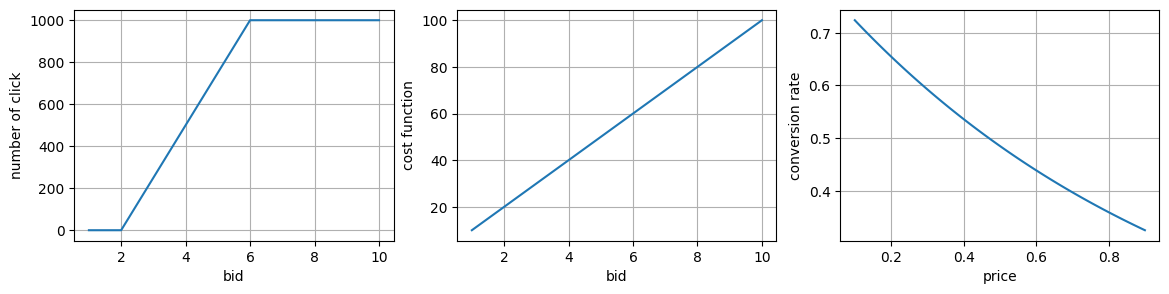

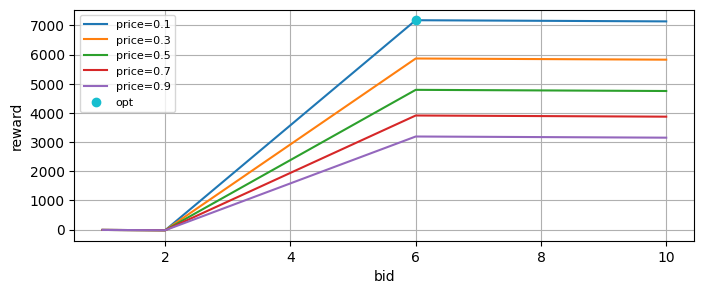

In [17]:
# Inputs for user class

F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 1000

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 10

def conversion_rate_f(price):
    return np.exp(-price) * 0.8

# Plot
plt.figure(figsize=(14,3))

xx = np.linspace(min(bids),max(bids),100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(min(bids),max(bids),100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(min(prices),max(prices),100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)


# Creating class

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)


# opt arm information
opt_arm_price = np.argmax(C1.conversion_rate_function(prices)) #optimal value of convertion rate between the arms
opt_price = prices[opt_arm_price]
opt_conversion_rate = C1.conversion_rate_function(opt_price)

opt_bid_arm = np.argmax(C1.n_daily_clicks_function(bids) * opt_conversion_rate * margin - C1.cum_daily_costs_function(bids)) #optimal value of convertion rate between the arms
opt_bid = bids[opt_bid_arm]
opt_n_daily_clicks = C1.n_daily_clicks_function(opt_bid)
opt_cum_daily_costs = C1.cum_daily_costs_function(opt_bid)

opt = opt_n_daily_clicks * opt_conversion_rate * margin - opt_cum_daily_costs
opt_list.append(opt)


# Plot
plt.figure(figsize=(8,3))
for price in prices:
    plt.plot(bids, C1.n_daily_clicks_function(bids) * C1.conversion_rate_function(price) * margin - C1.cum_daily_costs_function(bids), label = f'price={price}')
plt.plot(opt_bid, opt, 'o', color = "C9", label = "opt")
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(fontsize=8)
plt.grid(True)


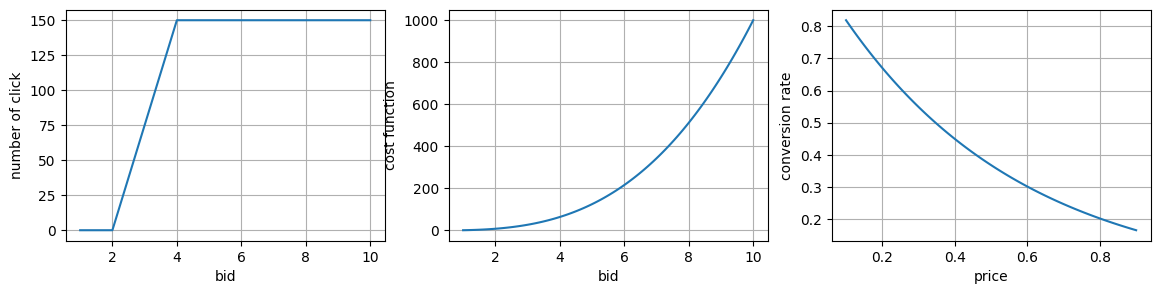

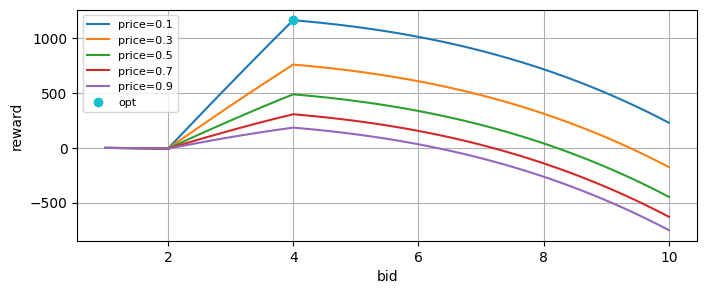

In [18]:
# Inputs for user class
F1 = 0
F2 = 1
def click_f(bid):
    bid_0 = 2
    bid_1 = 4
    max_clicks = 150

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks

def cost_f(bid):
    return (bid ** 3)

def conversion_rate_f(price):
    return np.exp(-2*price)

# Plot
plt.figure(figsize=(14,3))

xx = np.linspace(min(bids),max(bids),100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(min(bids),max(bids),100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(min(prices),max(prices),100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)


# Creating class

C2 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)


# opt arm information
opt_arm_price = np.argmax(C2.conversion_rate_function(prices)) #optimal value of convertion rate between the arms
opt_price = prices[opt_arm_price]
opt_conversion_rate = C2.conversion_rate_function(opt_price)

opt_bid_arm = np.argmax(C2.n_daily_clicks_function(bids) * opt_conversion_rate * margin - C2.cum_daily_costs_function(bids)) #optimal value of convertion rate between the arms
opt_bid = bids[opt_bid_arm]
opt_n_daily_clicks = C2.n_daily_clicks_function(opt_bid)
opt_cum_daily_costs = C2.cum_daily_costs_function(opt_bid)

opt = opt_n_daily_clicks * opt_conversion_rate * margin - opt_cum_daily_costs
opt_list.append(opt)

# Plot
plt.figure(figsize=(8,3))
for price in prices:
    plt.plot(bids, C2.n_daily_clicks_function(bids) * C2.conversion_rate_function(price) * margin - C2.cum_daily_costs_function(bids), label = f'price={price}')
plt.plot(opt_bid, opt, 'o', color = "C9", label = "opt")
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(fontsize=8)
plt.grid(True)


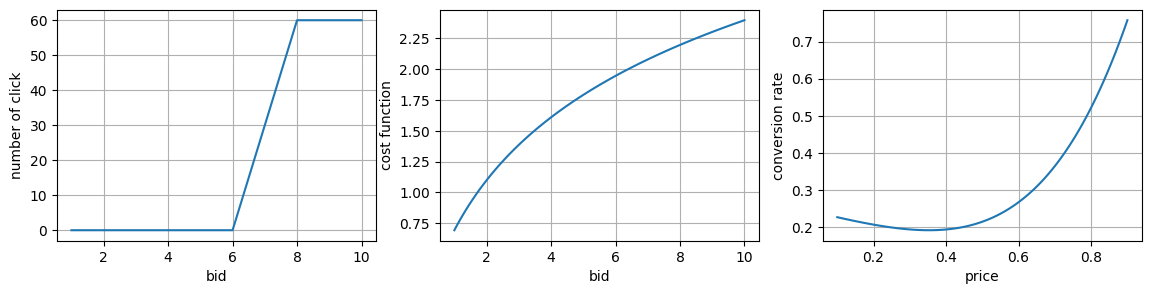

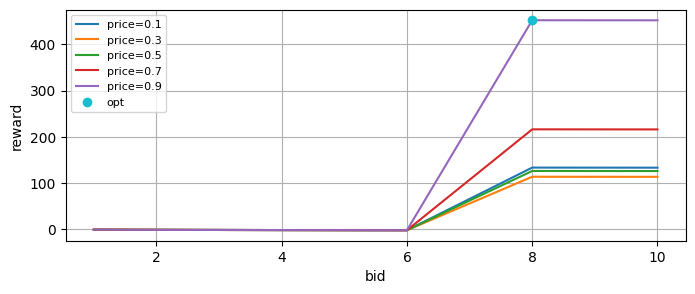

In [19]:
# Inputs for user class
F1 = 1
F2 = 0
def click_f(bid):
    bid_0 = 6
    bid_1 = 8
    max_clicks = 60

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks

def cost_f(bid):
    return np.log(bid + 1)

def conversion_rate_f(price):
    return np.exp(-price) /4 + price ** 4

# Plot
plt.figure(figsize=(14,3))

xx = np.linspace(min(bids),max(bids),100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(min(bids),max(bids),100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(min(prices),max(prices),100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)


# Creating class

C3 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)


# opt arm information
opt_arm_price = np.argmax(C3.conversion_rate_function(prices)) #optimal value of convertion rate between the arms
opt_price = prices[opt_arm_price]
opt_conversion_rate = C3.conversion_rate_function(opt_price)

opt_bid_arm = np.argmax(C3.n_daily_clicks_function(bids) * opt_conversion_rate * margin - C3.cum_daily_costs_function(bids)) #optimal value of convertion rate between the arms
opt_bid = bids[opt_bid_arm]
opt_n_daily_clicks = C3.n_daily_clicks_function(opt_bid)
opt_cum_daily_costs = C3.cum_daily_costs_function(opt_bid)

opt = opt_n_daily_clicks * opt_conversion_rate * margin - opt_cum_daily_costs
opt_list.append(opt)

# Plot
plt.figure(figsize=(8,3))
for price in prices:
    plt.plot(bids, C3.n_daily_clicks_function(bids) * C3.conversion_rate_function(price) * margin - C3.cum_daily_costs_function(bids), label = f'price={price}')
plt.plot(opt_bid, opt, 'o', color = "C9", label = "opt")
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(fontsize=8)
plt.grid(True)

In [29]:
user_classes = [C1, C2, C3]

real_contexts = [[(uc.F1, uc.F2)] for uc in user_classes ]
print(real_contexts)

[[(0, 0)], [(0, 1)], [(1, 0)]]


### UCB - known context structure

In [ ]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, user_classes)
    ucb_learner = UCB_FixedContextsLearner(bids, prices, margin, real_contexts)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward, features)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

Plot

In [ ]:
rewards_simulations = np.array(ucb_rewards_per_experiment)

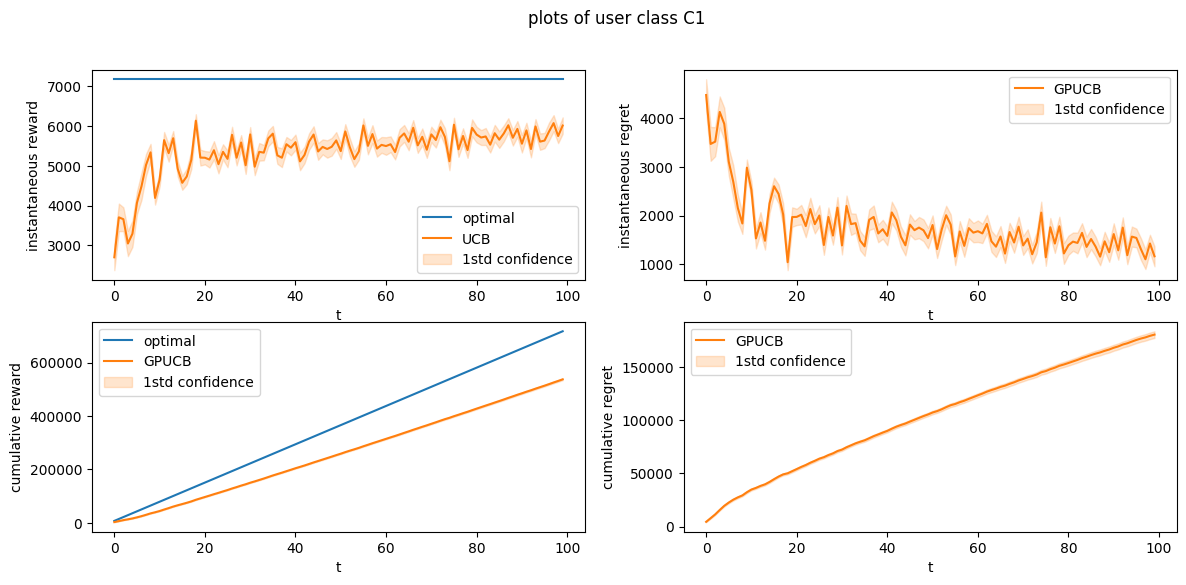

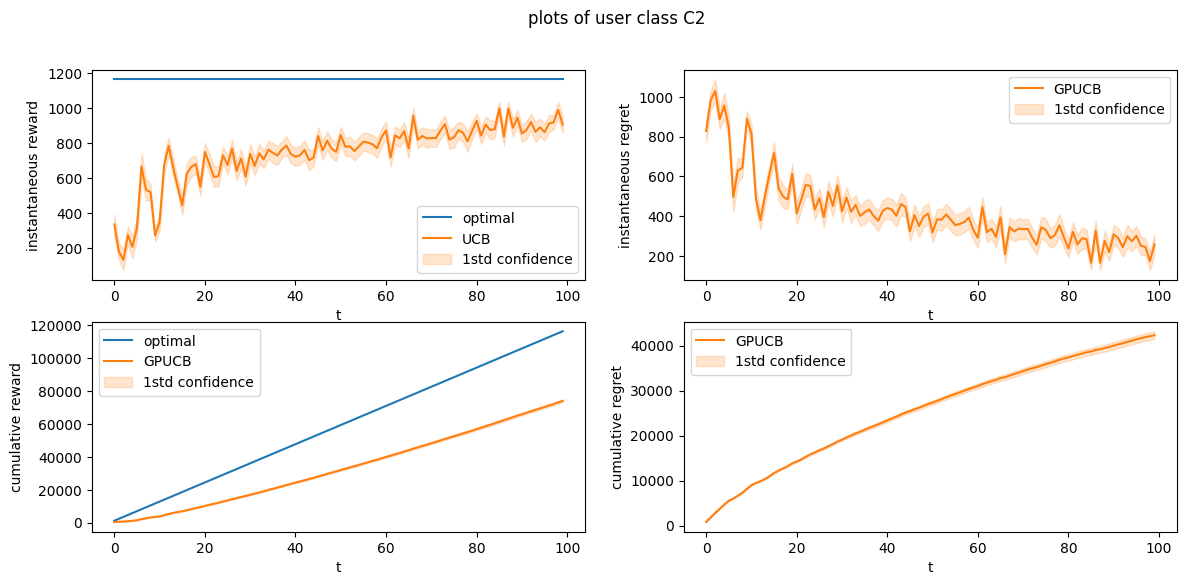

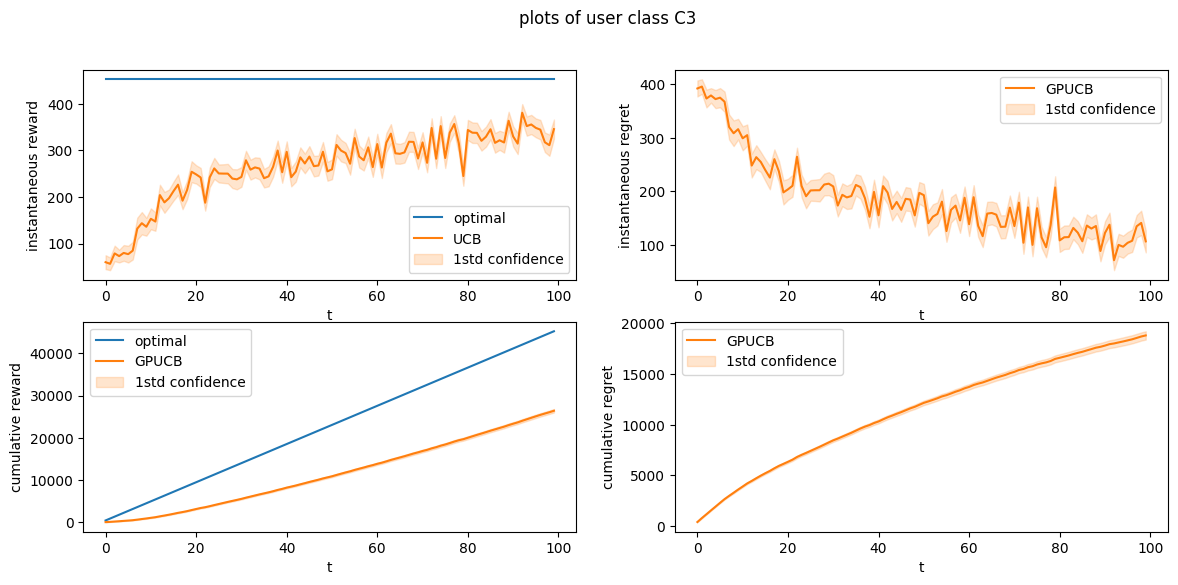

In [ ]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

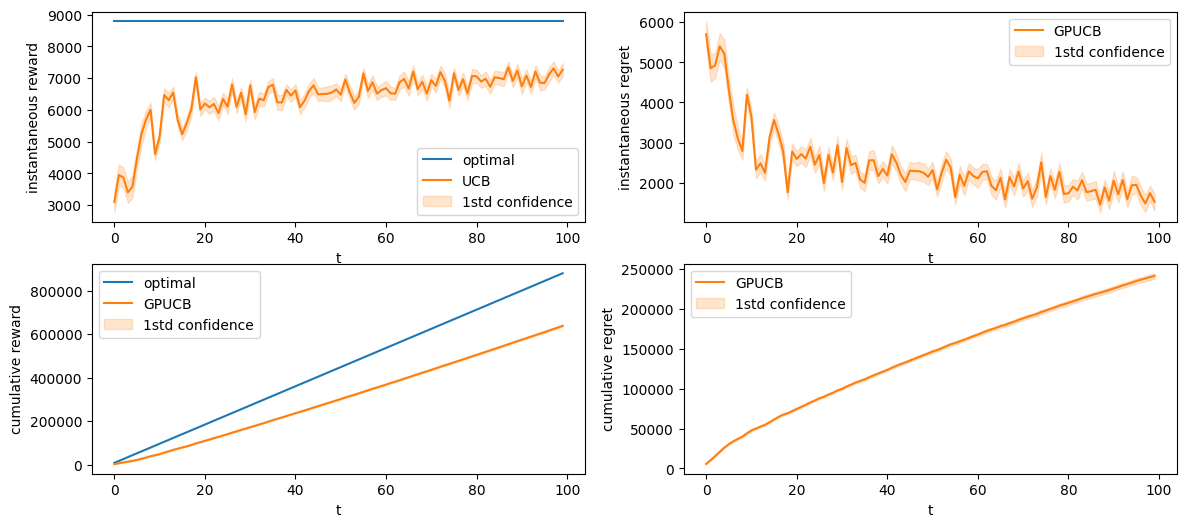

In [ ]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### UCB - unknown context structure & no context generation

In [ ]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, user_classes)
    ucb_learner = UCB_FixedContextsLearner(bids, prices, margin, [ [(0,0),(0,1),(1,0),(1,1)] ])

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward, features)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

Plot

In [ ]:
rewards_simulations = np.array(ucb_rewards_per_experiment)

In [ ]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

In [ ]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### UCB - unknown context structure with context generation algorithm

In [ ]:
# n_experiments = 50
window_context = 14

In [ ]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, user_classes)
    ucb_learner = UCB_ContextsGreadyLearner(bids, prices, margin, window_context)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward, features)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

Plot

In [ ]:
rewards_simulations = np.array(ucb_rewards_per_experiment)

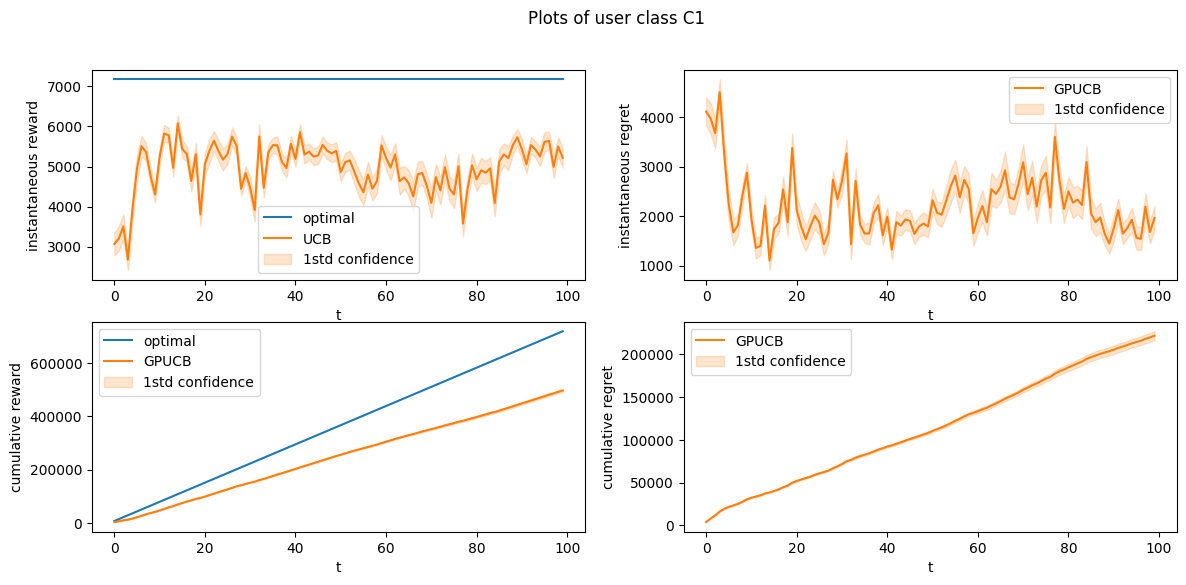

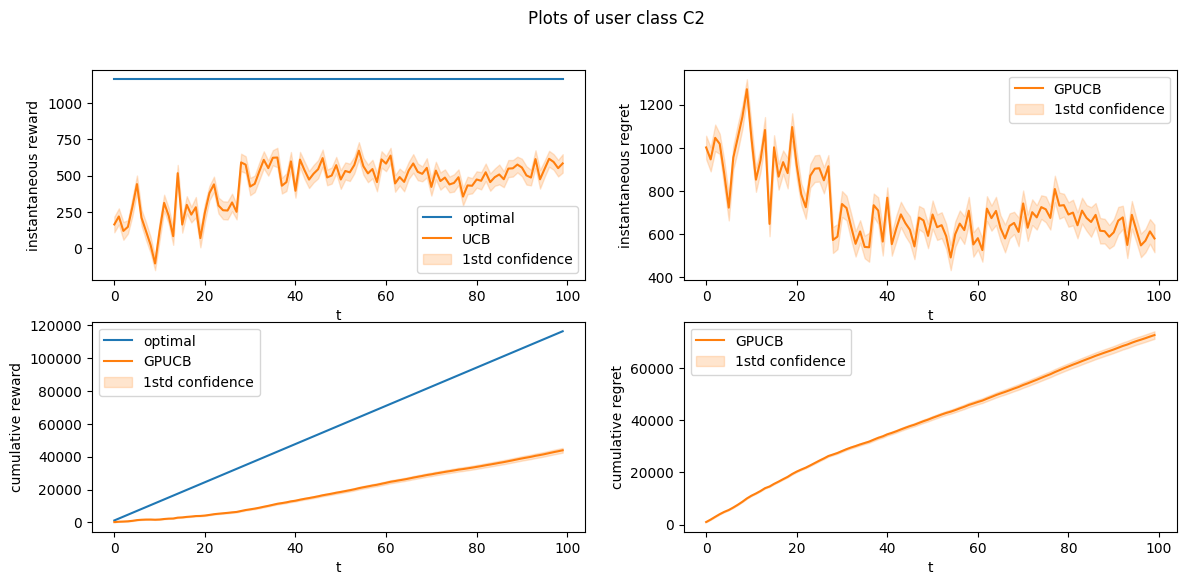

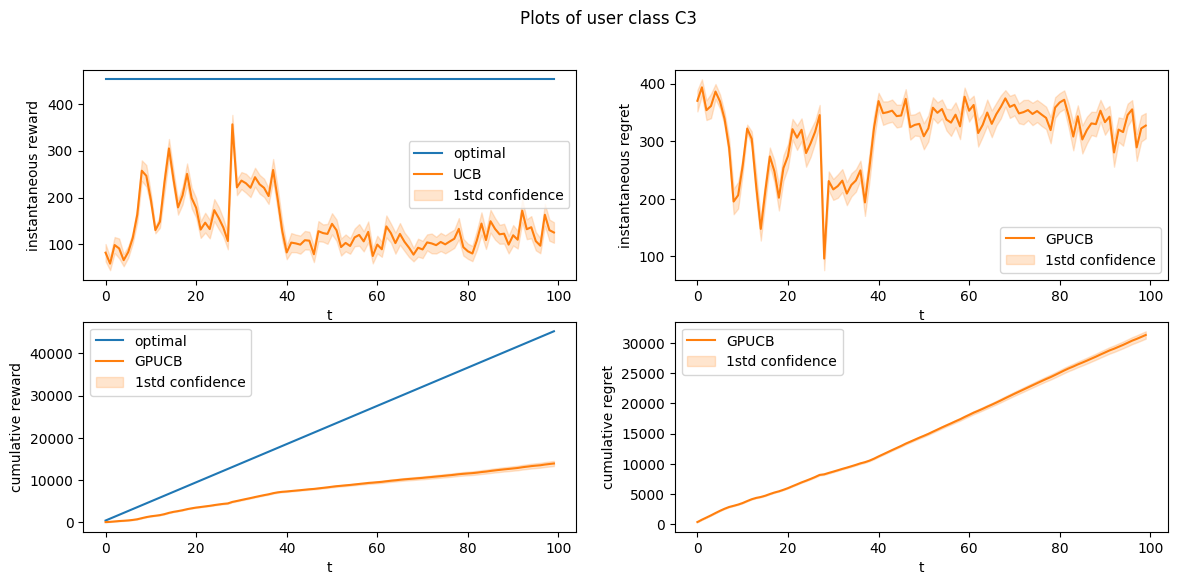

In [ ]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

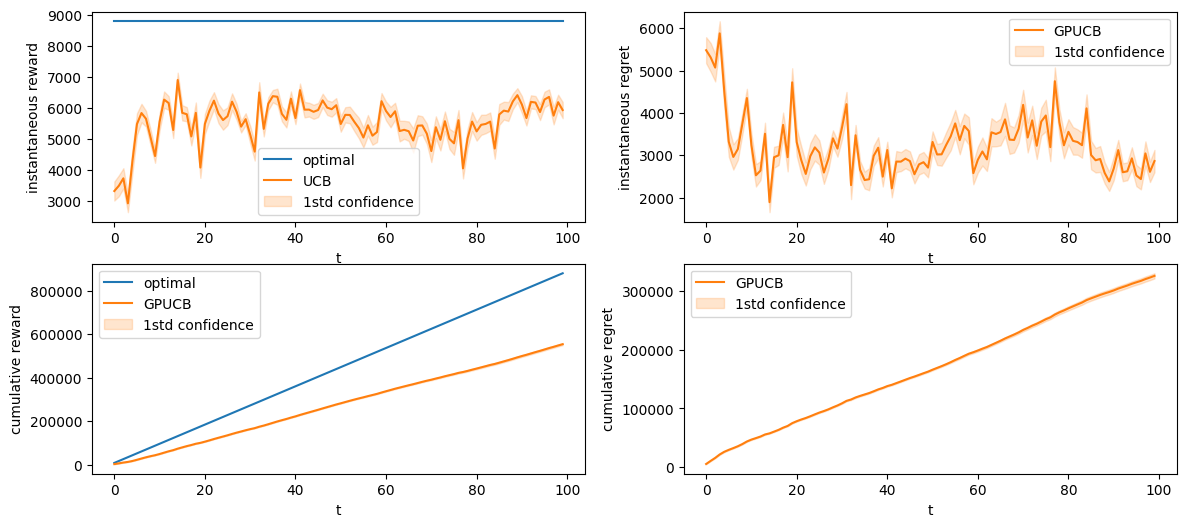

In [ ]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS - known context structure

In [23]:
# n_experiments = 5

In [ ]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, user_classes)
    ts_learner = TS_FixedContextsLearner(bids, prices, margin, real_contexts)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward, features)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

Plot

In [25]:
rewards_simulations = np.array(ts_rewards_per_experiment)

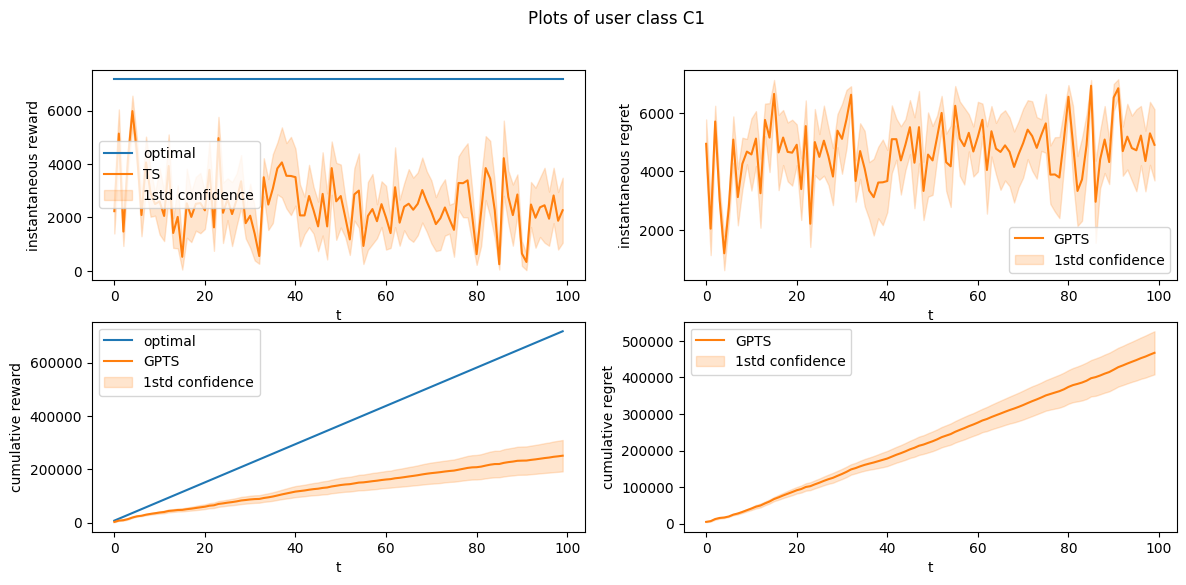

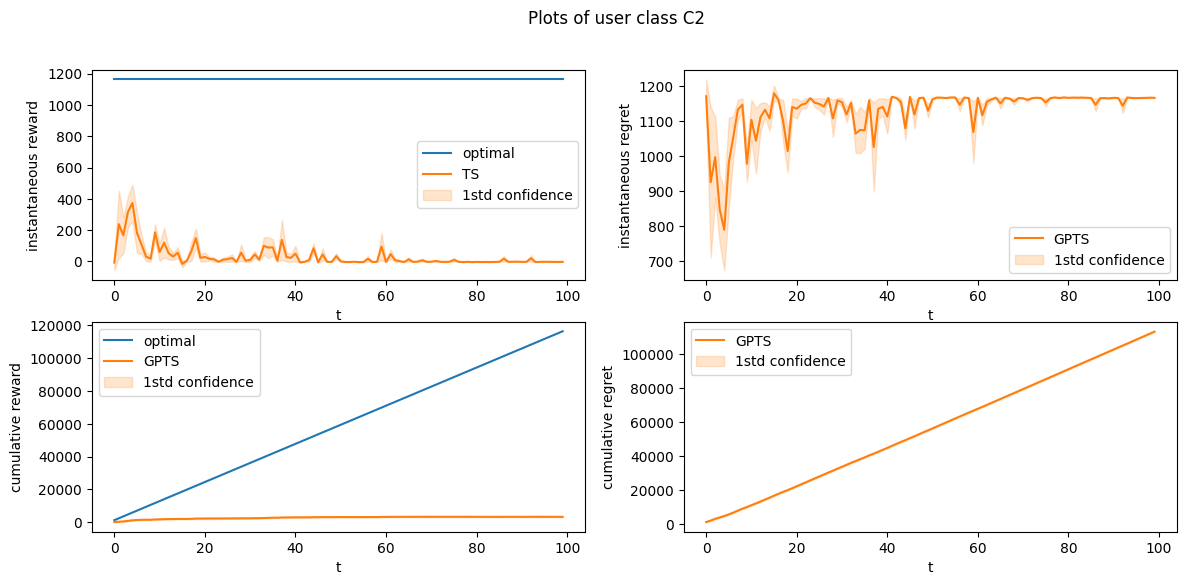

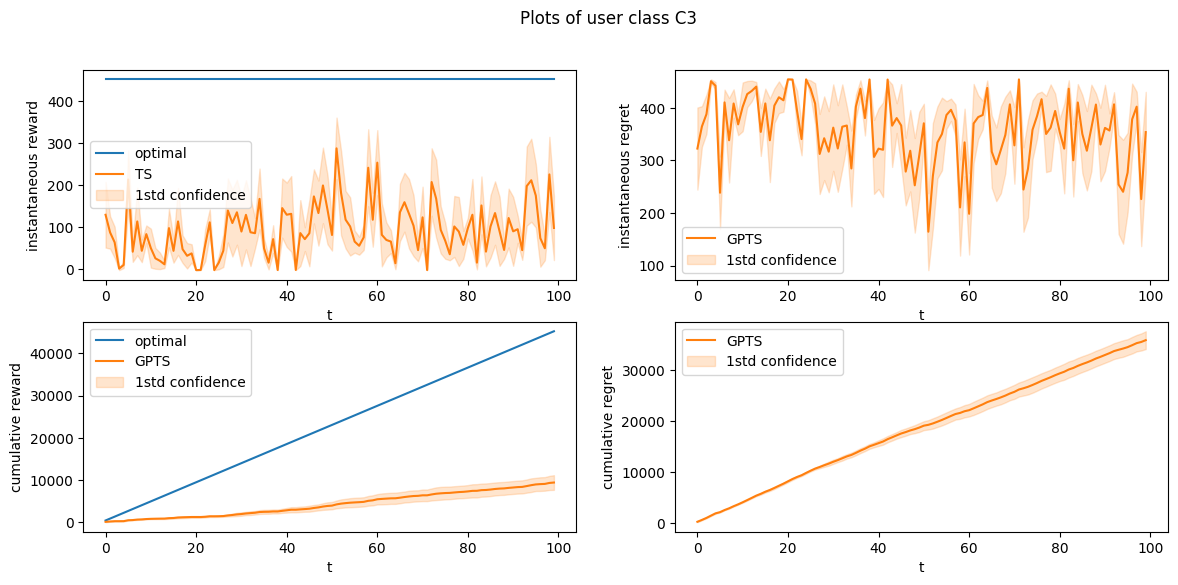

In [26]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

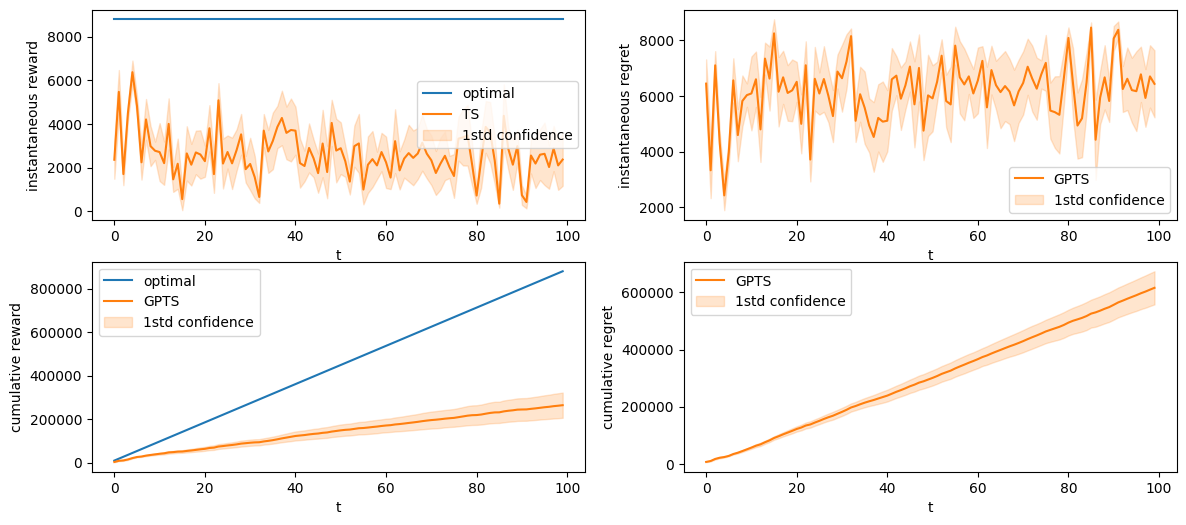

In [27]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS - unknown context structure & no context generation

In [ ]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, user_classes)
    ts_learner = TS_FixedContextsLearner(bids, prices, margin, [ [(0,0),(0,1),(1,0),(1,1)] ])

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward, features)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

Plot

In [ ]:
rewards_simulations = np.array(ts_rewards_per_experiment)

In [ ]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

In [ ]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS - unknown context structure with context generation algorithm

In [ ]:
# n_experiments = 50
window_context = 14

In [ ]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, user_classes)
    ts_learner = TS_ContextsGreadyLearner(bids, prices, margin, window_context)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward, features)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

Plot

In [ ]:
rewards_simulations = np.array(ts_rewards_per_experiment)

In [ ]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

In [ ]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

# Step 5

In [ ]:
"""
We don't define a non stationary user class, we just pass to the user class an array 
of conversion rate functions. Then in the environment class we count the number of functions
to define the number of phases.
"""

In [15]:
class NS_Environment:
    def __init__(self, prices, cost, n_daily_clicks, cum_daily_costs, user_class, horizon):
        
        self.userclass = user_class
        self.cost = cost        #temp
        self.prices = prices    #temp
        
        self.pricing_environment = PricingEnvironment(prices, cost, user_class)

        self.n_daily_clicks = max(int(n_daily_clicks), 0)
        self.cum_daily_costs = cum_daily_costs
        self.n_phases = len(user_class.conversion_rate_function(prices))
        self.conversion_probabilities = []
        for i in range(0, self.n_phases):
            self.conversion_probabilities.append([user_class.conversion_rate_function(p)[i] for p in prices])
        self.t = 0
        self.horizon = horizon
        self.phase_size = self.horizon/self.n_phases
        """ 
        here the 3 phases occur just once during the horizon (as seen in lectures).
        another option is to pass the lenght of the phases 
        """

    def round(self, pulled_arm):
        current_phase = int((self.t - self.horizon*int(self.t / self.horizon)) / self.phase_size)
        p = self.conversion_probabilities[current_phase][pulled_arm]
        self.t += 1
        reward = self.pricing_environment.round(pulled_arm, self.n_daily_clicks, self.cum_daily_costs)[current_phase]
        # reward = np.random.binomial(n_daily_clicks, p) * (self.prices[pulled_arm] - self.cost) - self.cum_daily_costs
        return reward

In [17]:
class SW_UCB1_Learner(Learner):
    def __init__(self, n_arms, window_size, support = (0,1)):
        """
        support: tuple
            the support interval of what we are learning
            e.g. in the case we are learning a probability p -> support = (0,1)
        """
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)

        self.window_size = window_size 
        self.pulled_arms = np.array([])

    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        

        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

        #-update confidences and means
        for a in range(self.n_arms):
            discount = np.array([])
            pull_history = self.pulled_arms[-self.window_size:] == a
            n_samples = np.sum(pull_history)
            for s in range(np.max([self.t - window_size + 1, 1]), self.t+1):
                discount = np.append(discount, np.power(0.99, self.t-s))
            n_samples_d = np.sum(discount*pull_history)                      #n_samples = np.sum(self.pulled_arms[-self.window_size:] == a)
            cum_rew = np.sum(self.rewards_per_arm[a][-n_samples:]) if n_samples > 0 else 0
            if n_samples > 0:
                self.empirical_means[a] = cum_rew / n_samples_d
                self.confidence[a] = self.c * np.sqrt(np.log(np.min([self.t, window_size]))/n_samples_d)
            else:
                self.empirical_means[a] = 0
                self.confidence[a] = np.inf
            #print('time: ' + str(self.t) + ', arm: ' + str(a) + ', nsamples: ' + str(n_samples_d) + '  ' + str(n_samples) + ', cumrew: ' + str(cum_rew) + ', emp mean: ' + str(self.empirical_means[a]) + ', conf: ' + str(self.empirical_means[a] + self.confidence[a]))
        #print('\n\n')
        self.update_observations(pulled_arm, reward)

In [18]:
class Custom_SW_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin, window_size):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin = margin

        self.conversion_rate_learner = SW_UCB1_Learner(n_arms, window_size)


    def pull_arm(self):
        # Obs:  the arm that maximizes the conversion rate is the one that maximizes the reward,
        #       so, the following arm is the arm we pull:
        idx_arm = self.conversion_rate_learner.pull_arm()
        
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks * self.margin)
        self.conversion_rate_learner.update(pulled_arm, alpha)

In [187]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.array([((np.exp(-0.1*price + 50))/np.exp(-0.1*50+50))*0.9, ((np.exp(-0.1*price + 50))/np.exp(-0.1*50+50))*0.9, ((np.exp(-0.1*price + 50))/np.exp(-0.1*50+50))*0.9])

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)


In [188]:
#Fixed parameters
n_arms = 5
T = 365
window_size =  4*int(np.sqrt(T)) # copied from profesor, should check if works for us

# in this step n_clicks and cost are given
# so let's fix a bid and compute n_clicks and cost
BID = 6
n_daily_clicks = int(C1.n_daily_clicks_function(BID))
cum_daily_costs = C1.cum_daily_costs_function(BID)

margin = 90


#setting the arms
prices = np.array([50,60,70,80,90])

#TODO: define optimal values for regret, clairvoyant...
opt_arm1 = np.argmax(C1.conversion_rate_function(prices)[0]) #optimal value of convertion rate between the arms
opt_arm2 = np.argmax(C1.conversion_rate_function(prices)[1])
opt_arm3 = np.argmax(C1.conversion_rate_function(prices)[2])

opt1 = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm1])[0] * margin - cum_daily_costs
opt2 = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm2])[1] * margin - cum_daily_costs
opt3 = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm3])[2] * margin - cum_daily_costs


n_experiments = 200

In [189]:
## UCB learner

sw_ucb_rewards_per_experiment = []

sw_ucb_conversion_rate_hat = np.zeros(len(prices))
sw_ucb_conversion_rate_bound = np.zeros(len(prices))

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')
    print(e)
    ns_env = NS_Environment(prices, margin, n_daily_clicks, cum_daily_costs, C1, T)
    sw_ucb_learner = Custom_SW_UCB_Learner(prices, n_daily_clicks, cum_daily_costs, margin, window_size)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = sw_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        sw_ucb_learner.update(pulled_arm, reward)
        
    sw_ucb_rewards_per_experiment.append(sw_ucb_learner.collected_rewards)

    sw_ucb_conversion_rate_hat += sw_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    sw_ucb_conversion_rate_bound += sw_ucb_learner.conversion_rate_learner.confidence/n_experiments




sw_ucb_std_inst = np.std(sw_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
sw_ucb_std_cum = np.std(np.cumsum(sw_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

sw_ucb_mean_rewards_hat = np.mean(sw_ucb_rewards_per_experiment, axis = 0)


0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

In [30]:
print(np.shape(sw_ucb_mean_rewards_hat))

(365,)


'plt.subplot(2,2,2)\nplt.xlabel("t")\nplt.ylabel("instantaneous regret")\nplt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")\nplt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = \'C1\')\nplt.legend()\n\nplt.subplot(2,2,3)\nplt.xlabel("t")\nplt.ylabel("cumulative reward")\nplt.plot(np.cumsum(np.full(T,opt)), label = "optimal")\nplt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")\nplt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = \'C1\')\nplt.legend()\n\nplt.subplot(2,2,4)\nplt.xlabel("t")\nplt.ylabel("cumulative regret")\nplt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")\nplt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = \'C1\')\nplt.legend()

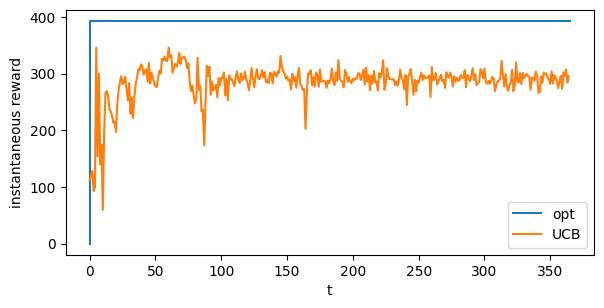

In [89]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, 122, 244, 365],[0, opt1, opt2, opt3], where='pre', label = "opt")
plt.plot(sw_ucb_mean_rewards_hat, color = 'C1', label = "UCB")
#plt.fill_between(np.arange(T), sw_ucb_mean_rewards_hat - sw_ucb_std_inst, sw_ucb_mean_rewards_hat + sw_ucb_std_inst, alpha = 0.2, color = 'C1')

plt.legend()

'''plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.legend()'''

In [80]:
#CHANGE DETECTION UCB

class CUSUM_UCB1_Learner(Learner):
    def __init__(self, n_arms, support = (0,12)):
        """
        support: tuple
            the support interval of what we are learning
            e.g. in the case we are learning a probability p -> support = (0,1)
        """
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)

        self.gp = np.zeros(n_arms)
        self.gm = np.zeros(n_arms)
        self.sp = np.zeros(n_arms)
        self.sm = np.zeros(n_arms)
        self.epsilon = 1
        self.h = 100
        self.M = np.zeros(n_arms)
        self.gpchart = []
        self.gmchart = []
        self.index = 0

    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.index += 1
        self.update_observations(pulled_arm, reward)

        #Model Updating:
        #-update mean
        self.empirical_means[pulled_arm] += (reward - self.empirical_means[pulled_arm]) / self.index
        # it's the same as: self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t

        #-update confidences
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            if n_samples > 0:
                self.confidence[a] = self.c * np.sqrt(np.log(self.index)/n_samples)
            #print('time: ' + str(self.t) + ', arm: ' + str(a) + ', emp mean: ' + str(self.empirical_means[a]) + ', conf: ' + str(self.empirical_means[a] + self.confidence[a]))
        #print('\n\n')
        if self.index <= 75:
            n_samples = len(self.rewards_per_arm[pulled_arm])
            self.M[pulled_arm] += (reward - self.M[pulled_arm]) / n_samples
            self.gpchart.append(0)
            self.gmchart.append(0)
        else:
            self.sp[pulled_arm] = reward - self.M[pulled_arm] - self.epsilon
            self.sm[pulled_arm] = self.M[pulled_arm] - reward - self.epsilon
            self.gp[pulled_arm] = max([0, self.gp[pulled_arm] + self.sp[pulled_arm]])
            self.gm[pulled_arm] = max([0, self.gm[pulled_arm] + self.sm[pulled_arm]])
            self.gpchart.append(max(self.gp))    # for the cahrts we use only the max, as it's the only one that matters
            self.gmchart.append(max(self.gm))
            if max(self.gp) >= self.h or max(self.gm) >= self.h:
                self.empirical_means = np.zeros(n_arms)
                self.confidence = np.full(n_arms, np.inf)
                self.gp = np.zeros(n_arms)
                self.gm = np.zeros(n_arms)
                self.sp = np.zeros(n_arms)
                self.sm = np.zeros(n_arms)
                self.index = 0
                self.M = np.zeros(n_arms)
                self.rewards_per_arm = x = [[] for i in range(n_arms)]
                
        

class Custom_CUSUM_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, cost):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.cost = cost

        self.conversion_rate_learner = CUSUM_UCB1_Learner(n_arms)


    def pull_arm(self):
        # Obs:  the arm that maximizes the conversion rate is the one that maximizes the reward,
        #       so, the following arm is the arm we pull:
        idx_arm = self.conversion_rate_learner.pull_arm()
        
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks)
        self.conversion_rate_learner.update(pulled_arm, alpha)

In [81]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 100

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.array([(np.exp(-0.1*price + 50))/np.exp(-0.1*50+50)*0.9, \
                    ((-np.power((price - 70), 4))/(np.power((50-70), 4))+1.2)*0.75, \
                    (np.exp(-0.1*price + 50))/np.exp(-0.1*50+50)*0.9])

""" def conversion_rate_f(price):
    return np.array([((np.exp(-0.05*price + 50))/np.exp(-0.05*50+50))*0.9, \
                    (np.exp(-0.1*price + 50))/np.exp(-0.1*50+50)*0.9, \
                    ((-np.power((price - 70), 4))/(np.power((50-70), 4))+1.2)*0.75]) """


C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)


In [82]:
#Fixed parameters
n_arms = 5
T = 365

# in this step n_clicks and cost are given
# so let's fix a bid and compute n_clicks and cost
BID = 6
n_daily_clicks = int(C1.n_daily_clicks_function(BID))
cum_daily_costs = C1.cum_daily_costs_function(BID)

cost = 40


#setting the arms
prices = np.array([50,60,70,80,90])

""" #TODO: define optimal values for regret, clairvoyant...
opt_arm1 = np.argmax(C1.conversion_rate_function(prices)[0]) #optimal value of convertion rate between the arms
opt_arm2 = np.argmax(C1.conversion_rate_function(prices)[1])
opt_arm3 = np.argmax(C1.conversion_rate_function(prices)[2])

opt1 = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm1])[0] * (prices[opt_arm1] - cost) - cum_daily_costs
opt2 = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm2])[1] * (prices[opt_arm2] - cost) - cum_daily_costs
opt3 = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm3])[2] * (prices[opt_arm3] - cost) - cum_daily_costs """

#TODO: define optimal values for regret, clairvoyant...
opt_value1 = np.max(C1.conversion_rate_function(prices)[0] * (prices - cost)) #optimal value of convertion rate between the arms
opt_value2 = np.max(C1.conversion_rate_function(prices)[1] * (prices - cost))
opt_value3 = np.max(C1.conversion_rate_function(prices)[2] * (prices - cost))

print(prices - cost)

opt1 = n_daily_clicks * opt_value1 - cum_daily_costs
opt2 = n_daily_clicks * opt_value2 - cum_daily_costs
opt3 = n_daily_clicks * opt_value3 - cum_daily_costs


n_experiments = 1000

[10 20 30 40 50]


In [83]:
## UCB learner

cusum_ucb_rewards_per_experiment = []
cusum_ucb_gpchart_per_experiment = []
cusum_ucb_gmchart_per_experiment = []

cusum_ucb_conversion_rate_hat = np.zeros(len(prices))
cusum_ucb_conversion_rate_bound = np.zeros(len(prices))

for e in range(0, 100):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(prices, cost, n_daily_clicks, cum_daily_costs, C1, T)
    cusum_ucb_learner = Custom_CUSUM_UCB_Learner(prices, n_daily_clicks, cum_daily_costs, cost)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = cusum_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        cusum_ucb_learner.update(pulled_arm, reward)
        
    cusum_ucb_rewards_per_experiment.append(cusum_ucb_learner.collected_rewards)
    cusum_ucb_gpchart_per_experiment.append(cusum_ucb_learner.conversion_rate_learner.gpchart)
    cusum_ucb_gmchart_per_experiment.append(cusum_ucb_learner.conversion_rate_learner.gmchart)

    cusum_ucb_conversion_rate_hat += cusum_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    cusum_ucb_conversion_rate_bound += cusum_ucb_learner.conversion_rate_learner.confidence/n_experiments




cusum_ucb_std_inst = np.std(cusum_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
cusum_ucb_std_cum = np.std(np.cumsum(cusum_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

cusum_ucb_mean_rewards_hat = np.mean(cusum_ucb_rewards_per_experiment, axis = 0)
cusum_ucb_mean_gpchart = np.mean(cusum_ucb_gpchart_per_experiment, axis = 0)
cusum_ucb_mean_gmchart = np.mean(cusum_ucb_gmchart_per_experiment, axis = 0)


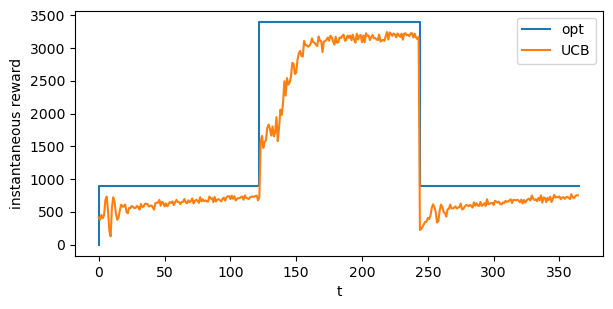

In [84]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, 122, 244, 365],[0, opt1, opt2, opt3], where='pre', label = "opt")
plt.plot(cusum_ucb_mean_rewards_hat, color = 'C1', label = "UCB")
#plt.fill_between(np.arange(T), sw_ucb_mean_rewards_hat - sw_ucb_std_inst, sw_ucb_mean_rewards_hat + sw_ucb_std_inst, alpha = 0.2, color = 'C1')

plt.legend()

365


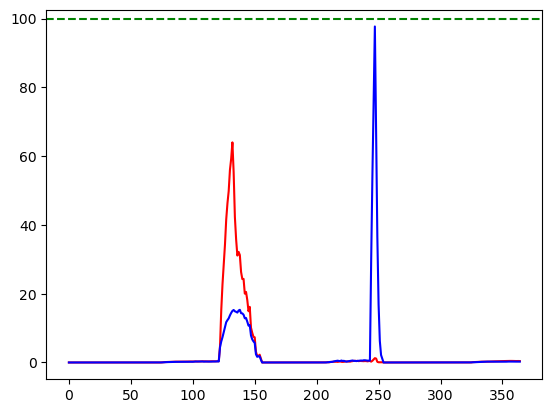

In [85]:
#BUILD CUMSUM CHARTS TO SHOW CHANGE DETECTION

plt.plot(cusum_ucb_mean_gpchart, color = 'r')
plt.plot(cusum_ucb_mean_gmchart, color = 'b')
plt.axhline(y = cusum_ucb_learner.conversion_rate_learner.h , color = 'g', linestyle = 'dashed')
print(len(cusum_ucb_learner.conversion_rate_learner.gpchart))



# Step 6

In [21]:
class EXP3_Learner(Learner):
    def __init__(self, n_arms, gamma):
        super().__init__(n_arms)
        self.weights = [1.0]*n_arms
        self.gamma = gamma

    def probability_distribution(self):
        sum_weights = sum(self.weights)
        return np.array([(1-self.gamma)*self.weights[i]/sum_weights + self.gamma/self.n_arms for i in range(self.n_arms)])

    def pull_arm(self):
        prob = self.probability_distribution()
        idx = np.random.choice(self.n_arms, p=prob)
        return idx, prob[idx]

    def estimated_rewards(self, reward_i, prob_i):
        return reward_i/prob_i
    
    def update(self, pulled_arm, prob_pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update weights
        est_reward_i = self.estimated_rewards(reward, prob_pulled_arm)
        self.weights[pulled_arm] = self.weights[pulled_arm]*np.exp(self.gamma*est_reward_i/self.n_arms)
        

class Custom_EXP3_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, cost, gamma):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        #self.margin = margin
        self.cost = cost

        self.conversion_rate_learner = EXP3_Learner(n_arms, gamma)

    def pull_arm(self):
        # Obs:  the arm that maximizes the conversion rate is the one that maximizes the reward,
        #       so, the following arm is the arm we pull:
        idx_arm, prob_idx = self.conversion_rate_learner.pull_arm()
        
        return idx_arm, prob_idx


    def update(self, pulled_arm, prob_pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks)
        self.conversion_rate_learner.update(pulled_arm, prob_pulled_arm, alpha)

First case

In [33]:
F1 = 0
F2 = 0

# User class
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 100
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks

def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.array([(np.exp(-0.05*price + 50)/np.exp(-0.05*50+50))*0.9, \
                      (np.exp(-0.1*price + 50)/np.exp(-0.1*50+50))*0.9, \
                    ((-np.power((price - 70), 4))/(np.power((50-70), 4))+1.2)*0.75])

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)


# Fixed parameters
n_arms = 5
T = 365
n_phases = 3
window_size = 4*int(np.sqrt(T)) # copied from profesor, should check if works for us

# Let's consider the simplified version in which we select fix the bid
BID = 6
n_daily_clicks = int(C1.n_daily_clicks_function(BID))
cum_daily_costs = C1.cum_daily_costs_function(BID)

cost = 40


#setting the arms
prices = np.array([50,60,70,80,90])


# Setting gamma parameter of EXP3
rho = 0.01
gamma = np.sqrt(3*np.log(2*len(prices)/rho)/(len(prices)*T))

#optimal value of conversion_rate*margin between the arms
opt_val = [0]*n_phases
for i in range(n_phases):
    #opt_arm[i] = np.argmax(C1.conversion_rate_function(prices)[i]) #optimal value of conversion rate between the arms for each phase
    opt_val[i] = np.max(C1.conversion_rate_function(prices)[i] * (prices - cost)) #optimal value of conversion rate between the arms for each phase

opt = [0]*n_phases
for i in range(n_phases):
    opt[i] = n_daily_clicks * opt_val[i] - cum_daily_costs

n_experiments = 1000    # t

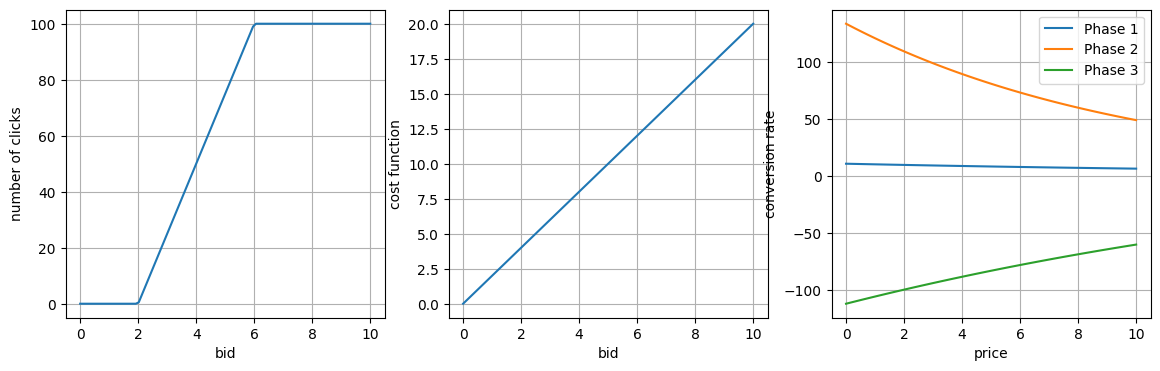

In [34]:
#Plots

plt.figure(figsize=(14,4))

#Number of clicks plot
xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of clicks')
plt.grid(True)

#Cost function plot
xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

#Conversion rate plots for each phase
for i in range(3):
    xx = np.linspace(0,10,100)
    plt.subplot(1,3,3)
    plt.plot(xx, conversion_rate_f(xx)[i])
    plt.xlabel('price')
    plt.ylabel('conversion rate')
    plt.grid(True)
    plt.legend(['Phase 1', 'Phase 2', 'Phase 3'])

In [35]:
## EXP3 learner
exp3_rewards_per_experiment = []

exp3_conversion_rate_hat = np.zeros(len(prices))
exp3_conversion_rate_bound = np.zeros(len(prices))


for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(prices, cost, n_daily_clicks, cum_daily_costs, C1, T)
    exp3_learner = Custom_EXP3_Learner(prices, n_daily_clicks, cum_daily_costs, cost, gamma)

    for t in range(0, T):       
        pulled_arm, prob_pulled_arm = exp3_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        exp3_learner.update(pulled_arm, prob_pulled_arm, reward)
    
    exp3_rewards_per_experiment.append(exp3_learner.collected_rewards)
    

exp3_std_inst = np.std(exp3_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
exp3_std_cum = np.std(np.cumsum(exp3_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

exp3_mean_rewards_hat = np.mean(exp3_rewards_per_experiment, axis = 0)

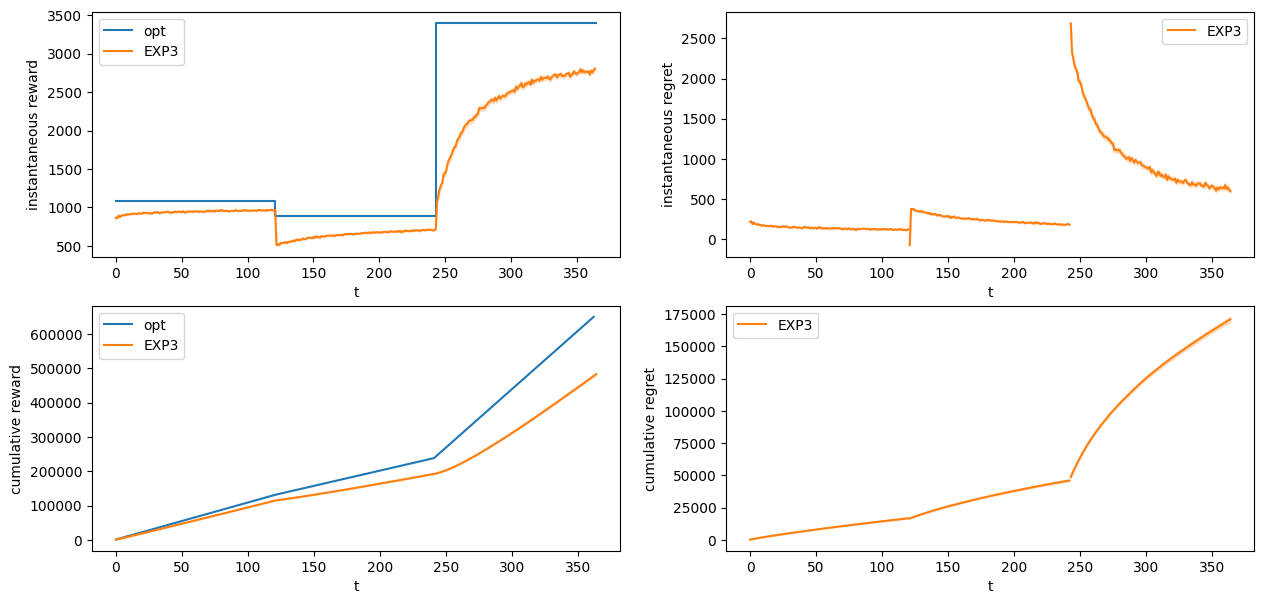

In [36]:
#Plots
plt.figure(figsize = (15,7))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, int(T/3), int(2*T/3), T], [opt[0], opt[0], opt[1], opt[2]], label = 'opt')
plt.plot(exp3_mean_rewards_hat, color = 'C1', label = "EXP3")
plt.fill_between(np.arange(T), exp3_mean_rewards_hat - exp3_std_inst, exp3_mean_rewards_hat + exp3_std_inst, alpha = 0.2, color = 'C1')
plt.legend()

#Instantaneous regret plot
for i in range(n_phases):
    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - exp3_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C1", label='EXP3')
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - exp3_mean_rewards_hat - exp3_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - exp3_mean_rewards_hat + exp3_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C1')
    if i == 0:
        plt.legend()


#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")

temp = np.array([])
for i in range(0, n_phases):
    temp = np.append(temp, np.full(int(T/3), opt[i]))
plt.plot(np.cumsum(temp), label='opt')

plt.plot(np.cumsum(exp3_mean_rewards_hat), color = "C1", label = "EXP3")
plt.fill_between(np.arange(T), np.cumsum(exp3_mean_rewards_hat) - exp3_std_cum, np.cumsum(exp3_mean_rewards_hat) + exp3_std_cum, alpha = 0.2, color = 'C1')
plt.legend()

#Cumulative regret plot 
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
temp_val_EXP3 = 0
for i in range(0, n_phases):
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C1", label = "EXP3")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - exp3_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + exp3_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C1')
    temp_val_EXP3 += np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])[-1]
    if i == 0:
        plt.legend()

Comparison with two Non-Stationary versions of UCB

In [37]:
## NS UCB1 - Sliding window
sw_ucb_rewards_per_experiment = []

sw_ucb_conversion_rate_hat = np.zeros(len(prices))
sw_ucb_conversion_rate_bound = np.zeros(len(prices)) 

## NS UCB1 - Change detection
cusum_ucb_rewards_per_experiment = []

cusum_ucb_conversion_rate_hat = np.zeros(len(prices))
cusum_ucb_conversion_rate_bound = np.zeros(len(prices))


for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(prices, cost, n_daily_clicks, cum_daily_costs, C1, T)
    sw_ucb_learner = Custom_SW_UCB_Learner(prices, n_daily_clicks, cum_daily_costs, cost, window_size)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = sw_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        sw_ucb_learner.update(pulled_arm, reward)
        
        
    sw_ucb_rewards_per_experiment.append(sw_ucb_learner.collected_rewards)
    sw_ucb_conversion_rate_hat += sw_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    sw_ucb_conversion_rate_bound += sw_ucb_learner.conversion_rate_learner.confidence/n_experiments 

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(prices, cost, n_daily_clicks, cum_daily_costs, C1, T)
    cusum_ucb_learner = Custom_CUSUM_UCB_Learner(prices, n_daily_clicks, cum_daily_costs, cost)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = cusum_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        cusum_ucb_learner.update(pulled_arm, reward)
        
    cusum_ucb_rewards_per_experiment.append(cusum_ucb_learner.collected_rewards)

    cusum_ucb_conversion_rate_hat += cusum_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    cusum_ucb_conversion_rate_bound += cusum_ucb_learner.conversion_rate_learner.confidence/n_experiments
    
sw_ucb_std_inst = np.std(sw_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
sw_ucb_std_cum = np.std(np.cumsum(sw_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

sw_ucb_mean_rewards_hat = np.mean(sw_ucb_rewards_per_experiment, axis = 0) 


cusum_ucb_std_inst = np.std(cusum_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
cusum_ucb_std_cum = np.std(np.cumsum(cusum_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

cusum_ucb_mean_rewards_hat = np.mean(cusum_ucb_rewards_per_experiment, axis = 0)

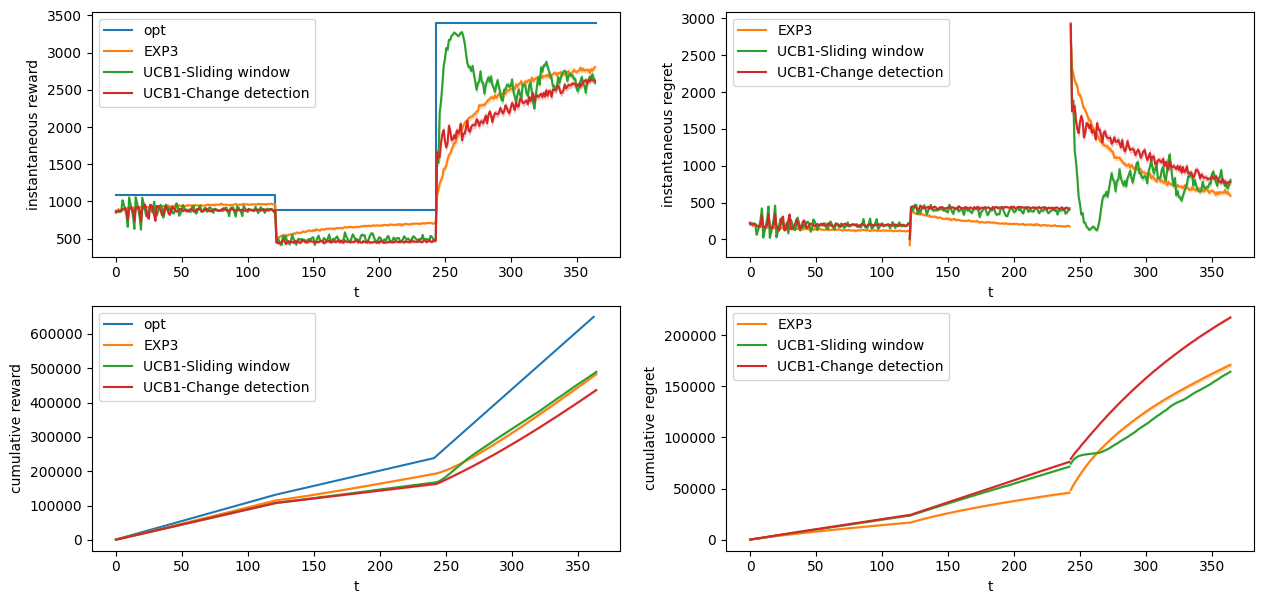

In [39]:
#Plots
plt.figure(figsize = (15,7))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, int(T/3), int(2*T/3), T], [opt[0], opt[0], opt[1], opt[2]], label = 'opt')
plt.plot(exp3_mean_rewards_hat, color = 'C1', label = "EXP3")
plt.fill_between(np.arange(T), exp3_mean_rewards_hat - exp3_std_inst, exp3_mean_rewards_hat + exp3_std_inst, alpha = 0.2, color = 'C1')
plt.plot(sw_ucb_mean_rewards_hat, color = 'C2', label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), sw_ucb_mean_rewards_hat - sw_ucb_std_inst, sw_ucb_mean_rewards_hat + sw_ucb_std_inst, alpha = 0.2, color = 'C2') 
plt.plot(cusum_ucb_mean_rewards_hat, color = 'C3', label = "UCB1-Change detection")
plt.fill_between(np.arange(T), cusum_ucb_mean_rewards_hat - cusum_ucb_std_inst, cusum_ucb_mean_rewards_hat + cusum_ucb_std_inst, alpha = 0.2, color = 'C3') 
plt.legend()

#Instantaneous regret plot
for i in range(n_phases):
    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - exp3_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C1", label='EXP3')
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - exp3_mean_rewards_hat - exp3_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - exp3_mean_rewards_hat + exp3_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C1')
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - sw_ucb_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - sw_ucb_mean_rewards_hat - sw_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - sw_ucb_mean_rewards_hat + sw_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C2')
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - cusum_ucb_mean_rewards_hat)[int(T*i/3):int(T*(i+1)/3)], color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), (opt[i] - cusum_ucb_mean_rewards_hat - cusum_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], (opt[i] - cusum_ucb_mean_rewards_hat + cusum_ucb_std_inst)[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C3')
    if i == 0:
        plt.legend()
#plt.legend(['opt', 'EXP3', 'UCB1-Sliding window', 'UCB1-Change detection'])



#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")

temp = np.array([])
for i in range(0, n_phases):
    temp = np.append(temp, np.full(int(T/3), opt[i]))
plt.plot(np.cumsum(temp), label='opt')

plt.plot(np.cumsum(exp3_mean_rewards_hat), color = "C1", label = "EXP3")
plt.fill_between(np.arange(T), np.cumsum(exp3_mean_rewards_hat) - exp3_std_cum, np.cumsum(exp3_mean_rewards_hat) + exp3_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(sw_ucb_mean_rewards_hat), color = "C2", label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), np.cumsum(sw_ucb_mean_rewards_hat) - sw_ucb_std_cum, np.cumsum(sw_ucb_mean_rewards_hat) + sw_ucb_std_cum, alpha = 0.2, color = 'C2')
plt.plot(np.cumsum(cusum_ucb_mean_rewards_hat), color = "C3", label = "UCB1-Change detection")
plt.fill_between(np.arange(T), np.cumsum(cusum_ucb_mean_rewards_hat) - cusum_ucb_std_cum, np.cumsum(cusum_ucb_mean_rewards_hat) + cusum_ucb_std_cum, alpha = 0.2, color = 'C3')

plt.legend()

#Cumulative regret plot 
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
temp_val_EXP3 = 0
temp_val_sw_UCB1 = 0
temp_val_cd_UCB1 = 0
for i in range(0, n_phases):
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C1", label = "EXP3")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - exp3_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + exp3_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C1')
    temp_val_EXP3 += np.cumsum(opt[i] - exp3_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])[-1]
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - sw_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + sw_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C2')
    temp_val_sw_UCB1 += np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])[-1]
    plt.plot(np.arange(int(T*i/3), int(T*(i+1)/3)),temp_val_cd_UCB1+np.cumsum(opt[i] -  cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]), color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(int(T*i/3), int(T*(i+1)/3)), temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) - cusum_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)]) + cusum_ucb_std_cum[int(T*i/3):int(T*(i+1)/3)], alpha = 0.2, color = 'C3')
    temp_val_cd_UCB1 += np.cumsum(opt[i] -  cusum_ucb_mean_rewards_hat[int(T*i/3):int(T*(i+1)/3)])[-1]
    if i == 0:
        plt.legend()

Higher degree of Non-Stationarity: 5 phases

In [60]:
F1 = 0
F2 = 0

# User class
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 100
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks

def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.array([np.exp(-price),np.exp(-0.95*price),np.exp(-0.9*price), np.exp(-0.85*price), np.exp(-0.8*price)])

def conversion_rate_f(price):
    return np.array([(np.exp(-0.05*price + 50)/np.exp(-0.05*50+50))*0.9, \
                     (np.exp(-0.1*price + 50)/np.exp(-0.1*50+50))*0.9, \
                     (np.exp(-0.01*price + 50)/np.exp(-0.01*50+50))*0.65, \
                     ((-np.power((price - 80), 4))/(np.power((50-80), 4))+1.2)*0.65, \
                     ((-np.power((price - 70), 4))/(np.power((50-70), 4))+1.2)*0.75])

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)


# Fixed parameters
n_arms = 5
T = 365
n_phases = 5
window_size = 4*int(np.sqrt(T)) # copied from profesor, should check if works for us

# Let's consider the simplified version in which we select fix the bid
BID = 6
n_daily_clicks = int(C1.n_daily_clicks_function(BID))
cum_daily_costs = C1.cum_daily_costs_function(BID)

cost = 40

# Setting the arms
prices = np.array([50,60,70,80,90])

# Setting gamma parameter of EXP3
rho = 0.01
gamma = np.sqrt(3*np.log(2*len(prices)/rho)/(len(prices)*T))

opt_val = [0]*n_phases
for i in range(n_phases):
    opt_val[i] = np.max(C1.conversion_rate_function(prices)[i] * (prices - cost)) #optimal value of conversion rate between the arms for each phase

opt = [0]*n_phases
for i in range(n_phases):
    opt[i] = n_daily_clicks * opt_val[i] - cum_daily_costs

n_experiments = 1000    # t
horizon = 50

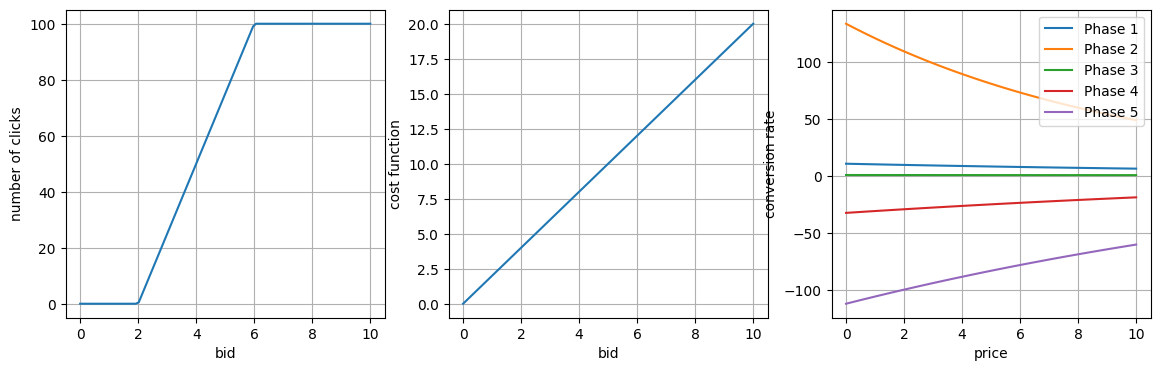

In [61]:
#Plots
plt.figure(figsize=(14,4))

#Number of clicks plot
xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of clicks')
plt.grid(True)

#Cost function plot
xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

#Conversion rate plots for each phase
for i in range(5):
    xx = np.linspace(0,10,100)
    plt.subplot(1,3,3)
    plt.plot(xx, conversion_rate_f(xx)[i])
    plt.xlabel('price')
    plt.ylabel('conversion rate')
    plt.grid(True)

plt.legend(['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5'])

In [62]:
## NS UCB1 - Sliding window
sw_ucb_rewards_per_experiment = []

sw_ucb_conversion_rate_hat = np.zeros(len(prices))
sw_ucb_conversion_rate_bound = np.zeros(len(prices)) 

## NS UCB1 - Change detection
cusum_ucb_rewards_per_experiment = []

cusum_ucb_conversion_rate_hat = np.zeros(len(prices))
cusum_ucb_conversion_rate_bound = np.zeros(len(prices))

## EXP3 learner
exp3_rewards_per_experiment = []

exp3_conversion_rate_hat = np.zeros(len(prices))
exp3_conversion_rate_bound = np.zeros(len(prices))


for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(prices, margin, n_daily_clicks, cum_daily_costs, C1, horizon)
    sw_ucb_learner = Custom_SW_UCB_Learner(prices, n_daily_clicks, cum_daily_costs, margin, window_size)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = sw_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        sw_ucb_learner.update(pulled_arm, reward)
        
        
    sw_ucb_rewards_per_experiment.append(sw_ucb_learner.collected_rewards)
    sw_ucb_conversion_rate_hat += sw_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    sw_ucb_conversion_rate_bound += sw_ucb_learner.conversion_rate_learner.confidence/n_experiments 

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(prices, margin, n_daily_clicks, cum_daily_costs, C1, horizon)
    cusum_ucb_learner = Custom_CUSUM_UCB_Learner(prices, n_daily_clicks, cum_daily_costs, margin)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = cusum_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        cusum_ucb_learner.update(pulled_arm, reward)
        
    cusum_ucb_rewards_per_experiment.append(cusum_ucb_learner.collected_rewards)

    cusum_ucb_conversion_rate_hat += cusum_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    cusum_ucb_conversion_rate_bound += cusum_ucb_learner.conversion_rate_learner.confidence/n_experiments

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(prices, margin, n_daily_clicks, cum_daily_costs, C1, horizon)
    exp3_learner = Custom_EXP3_Learner(prices, n_daily_clicks, cum_daily_costs, margin, gamma)

    for t in range(0, T):       
        pulled_arm, prob_pulled_arm = exp3_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        exp3_learner.update(pulled_arm, prob_pulled_arm, reward)
    
    exp3_rewards_per_experiment.append(exp3_learner.collected_rewards)
    
sw_ucb_std_inst = np.std(sw_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
sw_ucb_std_cum = np.std(np.cumsum(sw_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

sw_ucb_mean_rewards_hat = np.mean(sw_ucb_rewards_per_experiment, axis = 0) 


cusum_ucb_std_inst = np.std(cusum_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
cusum_ucb_std_cum = np.std(np.cumsum(cusum_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

cusum_ucb_mean_rewards_hat = np.mean(cusum_ucb_rewards_per_experiment, axis = 0)


exp3_std_inst = np.std(exp3_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
exp3_std_cum = np.std(np.cumsum(exp3_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

exp3_mean_rewards_hat = np.mean(exp3_rewards_per_experiment, axis = 0)

In [ ]:
#Plots
plt.figure(figsize = (15,7))
phases = []
for i in range(math.ceil(T/horizon)):
    phases.extend([0,1,2,3,4])
phases = phases[:math.ceil(T/ns_env.phase_size)]

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
opt_vec = [opt[0]]
opt_vec.extend([opt[i] for i in phases])
opt_T = [i*horizon/5 for i in range(len(phases))]
opt_T.append(opt_T[-1])
plt.step(opt_T, opt_vec, label = 'opt')
plt.plot(exp3_mean_rewards_hat, color = 'C1', label = "EXP3")
plt.fill_between(np.arange(T), exp3_mean_rewards_hat - exp3_std_inst, exp3_mean_rewards_hat + sw_ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(sw_ucb_mean_rewards_hat, color = 'C2', label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), sw_ucb_mean_rewards_hat - sw_ucb_std_inst, sw_ucb_mean_rewards_hat + sw_ucb_std_inst, alpha = 0.2, color = 'C2') 
plt.plot(cusum_ucb_mean_rewards_hat, color = 'C3', label = "UCB1-Change detection")
plt.fill_between(np.arange(T), cusum_ucb_mean_rewards_hat - cusum_ucb_std_inst, cusum_ucb_mean_rewards_hat + cusum_ucb_std_inst, alpha = 0.2, color = 'C3') 
plt.legend()

#Instantaneous regret plot
count = 0
phase_size = int(ns_env.phase_size)
add_phase = phase_size
for i in phases:
    if count+add_phase > len(exp3_mean_rewards_hat):
        add_phase = add_phase - (count + add_phase - len(exp3_mean_rewards_hat))
    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(np.arange(count, count+add_phase), (opt[i] - exp3_mean_rewards_hat)[count:count+add_phase], color = "C1", label='EXP3')
    plt.fill_between(np.arange(count, count+add_phase), (opt[i] - exp3_mean_rewards_hat - exp3_std_inst)[count:count+add_phase], (opt[i] - exp3_mean_rewards_hat + exp3_std_inst)[count:count+add_phase], alpha = 0.2, color = 'C1')
    plt.plot(np.arange(count, count+add_phase), (opt[i] - sw_ucb_mean_rewards_hat)[count:count+add_phase], color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(count, count+add_phase), (opt[i] - sw_ucb_mean_rewards_hat - sw_ucb_std_inst)[count:count+add_phase], (opt[i] - sw_ucb_mean_rewards_hat + sw_ucb_std_inst)[count:count+add_phase], alpha = 0.2, color = 'C2')
    plt.plot(np.arange(count, count+add_phase), (opt[i] - cusum_ucb_mean_rewards_hat)[count:count+add_phase], color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(count, count+add_phase), (opt[i] - cusum_ucb_mean_rewards_hat - cusum_ucb_std_inst)[count:count+add_phase], (opt[i] - cusum_ucb_mean_rewards_hat + cusum_ucb_std_inst)[count:count+add_phase], alpha = 0.2, color = 'C3')
    if count == 0:
        plt.legend()
    count += add_phase

#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")

temp = np.array([])
for i in phases:
    temp = np.append(temp, np.full(phase_size, opt[i]))
plt.plot(np.cumsum(temp))

plt.plot(np.cumsum(exp3_mean_rewards_hat), color = "C1", label = "EXP3")
plt.fill_between(np.arange(T), np.cumsum(exp3_mean_rewards_hat) - exp3_std_cum, np.cumsum(exp3_mean_rewards_hat) + exp3_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(sw_ucb_mean_rewards_hat), color = "C2", label = "UCB1-Sliding window")
plt.fill_between(np.arange(T), np.cumsum(sw_ucb_mean_rewards_hat) - sw_ucb_std_cum, np.cumsum(sw_ucb_mean_rewards_hat) + sw_ucb_std_cum, alpha = 0.2, color = 'C2')
plt.plot(np.cumsum(cusum_ucb_mean_rewards_hat), color = "C3", label = "UCB1-Change detection")
plt.fill_between(np.arange(T), np.cumsum(cusum_ucb_mean_rewards_hat) - cusum_ucb_std_cum, np.cumsum(cusum_ucb_mean_rewards_hat) + cusum_ucb_std_cum, alpha = 0.2, color = 'C3')
plt.legend()


#Cumulative regret plot 
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
temp_val_EXP3 = 0
temp_val_sw_UCB1 = 0
temp_val_cd_UCB1 = 0
count = 0
add_phase = phase_size
for i in phases:
    if count+add_phase > len(exp3_mean_rewards_hat):
        add_phase = add_phase - (count+add_phase - len(exp3_mean_rewards_hat))
    plt.plot(np.arange(count, count+add_phase),temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[count:count+add_phase]), color = "C1", label = "EXP3")
    plt.fill_between(np.arange(count, count+add_phase), temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[count:count+add_phase]) - exp3_std_cum[count:count+add_phase], temp_val_EXP3+np.cumsum(opt[i] - exp3_mean_rewards_hat[count:count+add_phase]) + exp3_std_cum[count:count+add_phase], alpha = 0.2, color = 'C1')
    temp_val_EXP3 += np.cumsum(opt[i] - exp3_mean_rewards_hat[count:count+add_phase])[-1]
    plt.plot(np.arange(count, count+add_phase),temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[count:count+add_phase]), color = "C2", label = "UCB1-Sliding window")
    plt.fill_between(np.arange(count, count+add_phase), temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[count:count+add_phase]) - sw_ucb_std_cum[count:count+add_phase], temp_val_sw_UCB1+np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[count:count+add_phase]) + sw_ucb_std_cum[count:count+add_phase], alpha = 0.2, color = 'C2')
    temp_val_sw_UCB1 += np.cumsum(opt[i] - sw_ucb_mean_rewards_hat[count:count+add_phase])[-1]
    plt.plot(np.arange(count, count+add_phase),temp_val_cd_UCB1+np.cumsum(opt[i] -  cusum_ucb_mean_rewards_hat[count:count+add_phase]), color = "C3", label = "UCB1-Change detection")
    plt.fill_between(np.arange(count, count+add_phase), temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat[count:count+add_phase]) - cusum_ucb_std_cum[count:count+add_phase], temp_val_cd_UCB1+np.cumsum(opt[i] - cusum_ucb_mean_rewards_hat[count:count+add_phase]) + cusum_ucb_std_cum[count:count+add_phase], alpha = 0.2, color = 'C3')
    temp_val_cd_UCB1 += np.cumsum(opt[i] -  cusum_ucb_mean_rewards_hat[count:count+add_phase])[-1]
    if count == 0:
        plt.legend()
    count += add_phase